# AI-powered bond ratings - a case of ordinal classification with imbalanced datasets
### Final Project in Quantitative Risk Management

By: Erik Konstenius

# Imports

In [284]:
# general
import pandas as pd
import numpy as np
import tensorflow as tf
import missingno as msno
from matplotlib.ticker import StrMethodFormatter

# data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# preproceessing - dealing with nulls
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# preproceessing - dealing with nulls
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # oversampling techniques

# modelling - classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers

# modelling - regression
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR

# evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_curve, roc_auc_score,confusion_matrix,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# tuning
import optuna
from optuna.samplers import TPESampler

# explainability
from scipy.stats.stats import pearsonr # correlation
from sklearn.inspection import permutation_importance
import shap
import warnings

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_excel(r"C:\Users\Erik Konstenius\OneDrive\Skrivbord\QRM\main_data.xlsx")

In [3]:
df

issuer          isin sp_rating  \
0                               HSBC Holdings PLC  US404280DQ93        A-   
1                               HSBC Holdings PLC  US404280DS59       BBB   
2                               HSBC Holdings PLC  US404280DR76        A-   
3              Sudzucker International Finance BV  XS2550868801      BBB-   
4                                    Barclays PLC  US06738ECC75       BBB   
...                                           ...           ...       ...   
4995                      Standard Chartered Bank  HK0000854163        A+   
4996             Credit Agricole Home Loan SFH SA  FR0014007VS7       AAA   
4997  Holding d'Infrastructures de Transport SASU  FR0013298684      BBB-   
4998                         Brambles Finance PLC  XS1577950667      BBB+   
4999                                      Sky Ltd  XS1321424670        A-   

     moody_rating fitch_rating bbg_composite_rating country     bbg_ticker  \
0              A3           A+                   A-      GB  BZ977954 Corp   
1            Baa1           A-                 BBB+      GB  BZ977957 Corp   
2              A3           A+                   A-      GB  BZ977956 Corp   
3             NaN          NaN                   NR      NL  BZ843109 Corp   
4            Baa2            A                 BBB+      GB  ZN018163 Corp   
...           ...          ...                  ...     ...            ...   
4995           A1          NaN                   A+      GB  BW821938 Corp   
4996          Aaa          AAA                  AAA      FR  BT573368 Corp   
4997        Baa3u          BBB                 BBB-      FR  AP971138 Corp   
4998         Baa1          NaN                 BBB+      GB  AP138040 Corp   
4999           A3           A-                   A-      GB  QJ714831 Corp   

      amount_issued  issue_date total_assets debt_to_common_equity  \
0      1.795378e+09  03-11-2022      2957939            234.178439   
1      2.051860e+09  03-11-2022      2957939            234.178439   
2      2.308342e+09  03-11-2022      2957939            234.178439   
3      4.000000e+08  31-10-2022       8441.4             94.984488   
4      1.518255e+09  02-11-2022      1384285            482.479855   
...             ...         ...          ...                   ...   
4995   7.397104e+07  06-06-2022       544791            617.491006   
4996   1.250000e+09  27-01-2022      2073955           1007.720002   
4997   5.000000e+08  27-11-2017     7736.529             389.41484   
4998   5.000000e+08  04-10-2017   1663.95238           1629.533982   
4999   5.000000e+08  17-11-2015       275905            111.621155   

                   i_spread_mid total_debt_total_capital  \
0                    227.995529                66.570527   
1                    399.580475  #N/A Requesting Data...   
2                    301.136169                66.570527   
3                     212.72496  #N/A Requesting Data...   
4                    259.072906  #N/A Requesting Data...   
...                         ...                      ...   
4995  #N/A Field Not Applicable  #N/A Requesting Data...   
4996                  21.757616  #N/A Requesting Data...   
4997                  50.626286                 79.56435   
4998                  67.331566  #N/A Requesting Data...   
4999                  44.611172  #N/A Requesting Data...   

                     currency    adjusted_duration_mid  \
0                 #N/A Review              #N/A Review   
1     #N/A Requesting Data...  #N/A Requesting Data...   
2     #N/A Requesting Data...  #N/A Requesting Data...   
3     #N/A Requesting Data...  #N/A Requesting Data...   
4     #N/A Requesting Data...  #N/A Requesting Data...   
...                       ...                      ...   
4995  #N/A Requesting Data...  #N/A Requesting Data...   
4996  #N/A Requesting Data...  #N/A Requesting Data...   
4997  #N/A Requesting Data...  #N/A Requesting Data...   
4998  #N/A Requesting Data...  #N/A Req

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   issuer                     5000 non-null   object 
 1   isin                       5000 non-null   object 
 2   sp_rating                  4381 non-null   object 
 3   moody_rating               4205 non-null   object 
 4   fitch_rating               3337 non-null   object 
 5   bbg_composite_rating       5000 non-null   object 
 6   country                    5000 non-null   object 
 7   bbg_ticker                 5000 non-null   object 
 8   amount_issued              5000 non-null   float64
 9   issue_date                 5000 non-null   object 
 10  total_assets               4997 non-null   object 
 11  debt_to_common_equity      4862 non-null   object 
 12  i_spread_mid               4750 non-null   object 
 13  total_debt_total_capital   4985 non-null   objec

# Fix datatypes

In [5]:
df = df.replace('#N/A Field Not Applicable', np.nan)
df = df.replace('#N/A Requesting Data...', np.nan)
df = df.replace('#N/A Review', np.nan)

In [6]:
df = df.astype({'issuer': 'str', 'isin': 'str', 'sp_rating' : 'str', 
                'moody_rating': 'str', 'fitch_rating': 'str', 'bbg_composite_rating' : 'str',
                'country' : 'str', 'bbg_ticker': 'str', 'amount_issued': 'float64',
                'issue_date' : 'datetime64', 'total_assets' : 'float64', 'debt_to_common_equity' : 'float64',
                'i_spread_mid' : 'float64', 'total_debt_total_capital' : 'float64', 
                'currency' : 'str', 'adjusted_duration_mid' : 'float64', 
                'maturity_years_from_today' : 'float64', 'active_bookrunners' : 'str'})

In [7]:
# as NaNs are converted to "nan" I need to convert the nan back to NaNs 
df = df.replace('nan', np.nan)

Next, we convert the ratings to numerical values based on the popular conversion table shown below. Will do it in the Pythonic way at let the rankings start at 0. This is necessary for some ML algorithms.  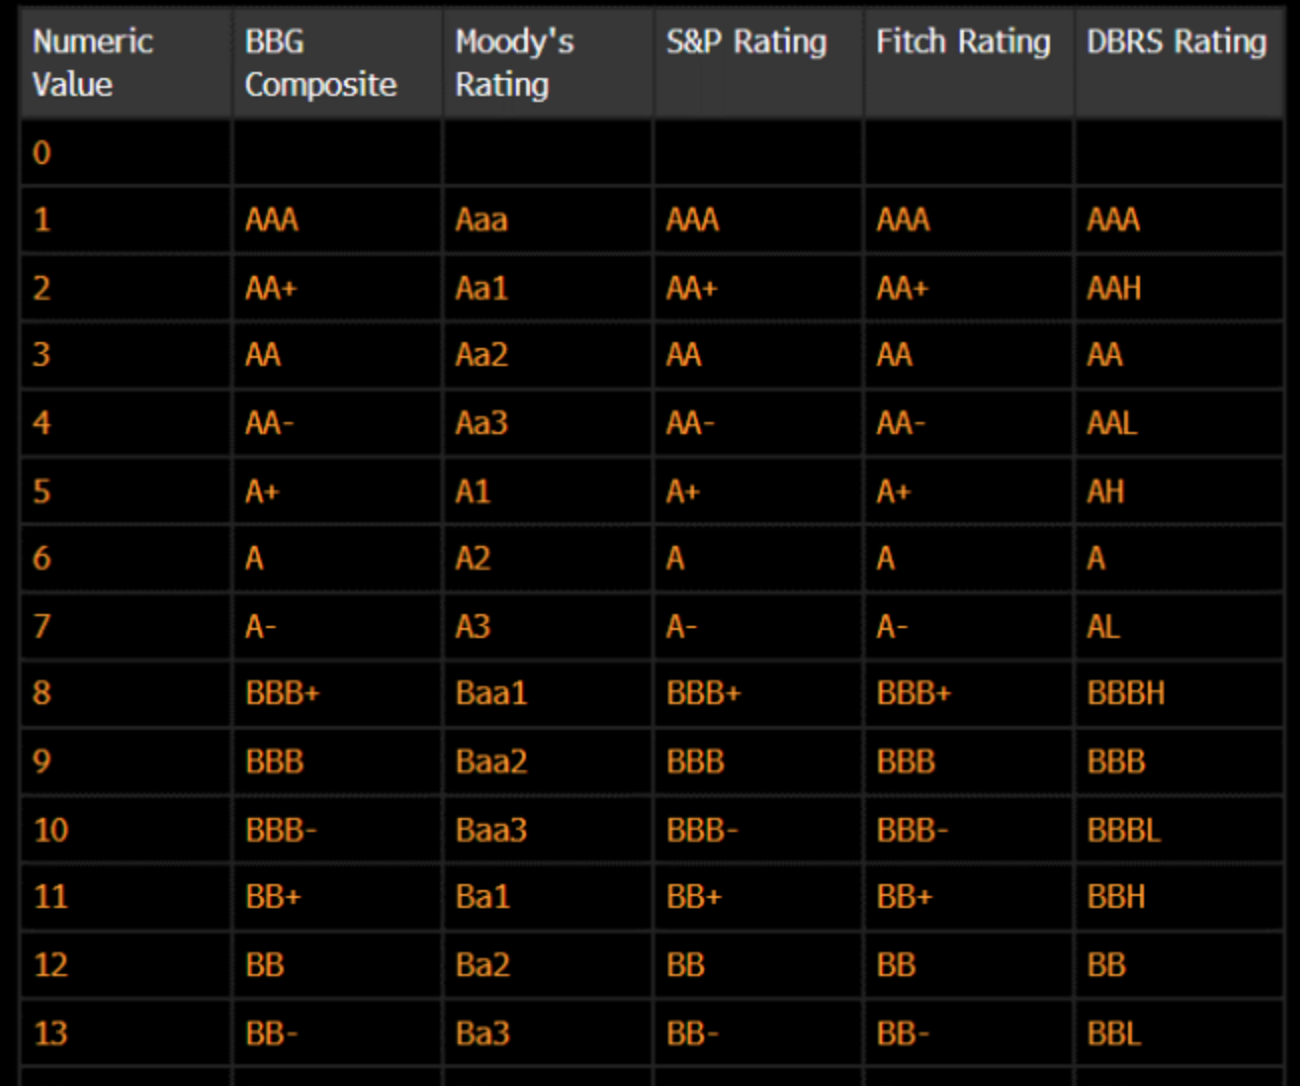

In [8]:
print("Unique Moody ratings: " + str(df["moody_rating"].unique()))
print("Unique Fitch ratings: " + str(df["fitch_rating"].unique()))
print("Unique S&P ratings: " + str(df["sp_rating"].unique()))

Unique Moody ratings: ['A3' 'Baa1' nan 'Baa2' 'Baa3' 'B1' 'B3' 'B2' 'Caa1' 'A1' 'Ba3' 'A2' 'Aa2'
 'Ba2' 'Aaa' 'Aa3' 'Ba3 *-' 'Ba1' 'B1 *+' 'Aa1' 'WR' 'Caa2' 'Ba2u' 'Ba3u'
 'B2 *-' 'Baa2u' 'Caa3' 'NR' 'Ca' 'Baa3u *-' 'Baa3u' 'Baa1u' 'Caa1 *+'
 'Caa2 *+' 'A3u' 'Ba1 *+' 'A3 *-' 'C' 'Aa1u' 'Aa2u' 'Baa2 *+']
Unique Fitch ratings: ['A+' 'A-' nan 'A' 'BBB' 'BB' 'B+' 'WD' 'BB-(EXP)' 'AA-' 'CCC+' 'BBB+'
 'A-u' 'BBB-' 'BBB+u' 'AA+' 'BB+' 'BB-' 'AAA' 'AA' 'B' 'BBBu' 'B-' 'AA-u'
 'BBB+ *+' 'CCC' 'A+u' 'BBB *-' 'NR' 'Au' 'AAAu' 'B- *-' 'AAu' 'BB *-'
 'BB+ *-' 'A- *' 'A+ *' 'A+u(EXP)' 'BBB- *+' 'BBB-(EXP)' 'A- *-' 'BBB- *-']
Unique S&P ratings: ['A-' 'BBB' 'BBB-' nan 'B+' 'A- *-' 'BB' 'B-' 'B' 'CCC+' '(P)B' 'A' 'BBB+'
 'AA-' 'C' 'BB-' 'AA+' 'A+' 'BB+' 'BBB *-' 'B *' 'CCC' 'AAA' 'BBB- *-'
 'B *+' 'B+ *+' 'CC' 'NR' 'AA' '(P)AAA' 'CCC-' 'BBB *+' 'CCC+ *-' 'BB- *'
 'CCC+ *+' 'CCC+ *' 'BBB- *+' 'CCC-p' 'B+ *-' 'BBB+ *-' 'A-1+' '(P)CCC']


In [9]:
df = df.replace({'sp_rating' : { 'AAA' : 0, 'AAAu':0, 'AA+' : 1, 'AA' : 2, 'AA-' : 3, 'A+' : 4, 'A' : 6,
                'Au':5,'A-' : 6, 'A- *-':6, 'A-1+':6, 'BBB+' : 7, 'BBB+ *-':7, 'BBB' : 8, 'BBB *+':8,
                'BBB *-':8, 'BBB- *+':9, 'BBB- *-':9, 'BBB-' : 9, 'BB+' : 10,'BB' : 11, 'BB-' : 12, 
                'BB- *':12, 'B+' : 13, 'B+ *-':13 , 'B+ *+':13, 'B' : 14, 'B *':14, 'B *+': 14,
                'B-' : 15, 'B- *-':15,'CCC+' : 16, 'CCC+ *':16, 'CCC+ *-':16, 'CCC+ *+':16, 'CCC' : 17, 'CCC-' : 18,
                'CC' : 20, 'CC-' : 21, '(P)B':np.nan, 'C':np.nan, 'NR': np.nan, 
                '(P)AAA':np.nan,'CCC-p':np.nan, '(P)CCC':np.nan}})

df = df.replace({'fitch_rating' : { 'AAA' : 0, 'AAAu':0,'AA+' : 1, 'AA' : 2, 'AAu':2,'AAu':2, 'AA-' : 3, 'AA-u':3,
                'A+' : 4, 'A+ *':4, 'A+u(EXP)':4, 'A+u':4, 'A' : 5, 'Au':5,'A-' : 6, 'A- *':6, 'A- *-':6, 'A-u':6, 'BBB+' : 7,
                'BBB+u':7, 'BBB+ *+':7, 'BBB' : 8, 'BBB *-':8, 'BBBu':8, 'BBB-' : 9,
                'BBB-(EXP)':9, 'BBB- *-':9, 'BBB- *+':9, 'BB+' : 10, 'BB+ *-':10,'BB' : 11, 'BB *-':12, 'BB-' : 12,
                'BB-(EXP)': 12, 'B+' : 13, 'B' : 14, 'B-' : 15, 'B- *-':15, 'CCC+' : 16, 'CCC' : 17,
                'CCC-' : 18, 'CC' : 20, 'WD':np.nan, 'NR':np.nan}})

df = df.replace({'moody_rating' : { 'Aaa' : 0, 'Aa1+' : 1, 'Aa1' : 1, 'Aa1u' : 1, 'Aa2' : 2,
                'Aa2u':2, 'Aa3' : 3, 'A1' : 4, 'A2' : 5,'A3' : 6, 'A3 *-':6, 'A3u':6,
                'Baa1' : 7, 'Baa1u':7, 'Baa2' : 8, 'Baa2u' : 8, 'Baa2 *+':8, 'Baa3' : 9,'Baa3u':9,
                'Baa3u *-' : 9, 'Ba1' : 10, 'Ba1 *+' : 10,'Ba2' : 11, 'Ba2u' : 11, 'Ba3' : 12,
                'Ba3u' : 12, 'Ba3 *-': 12, 'B1' : 13,'B1 *+' :13, 'B2' : 14,'B2 *-' : 14,
                'B3' : 15,'Caa1' : 16, 'Caa1 *+':16,'Caa2' : 17, 'Caa2 *+':17, 'Caa3' : 18,
                'Ca' : 20, 'WR' : np.nan, 'C': np.nan, 'NR': np.nan}})

In [10]:
print("Unique Moody ratings: " + str(df["moody_rating"].unique()))
print("Unique Fitch ratings: " + str(df["fitch_rating"].unique()))
print("Unique S&P ratings: " + str(df["sp_rating"].unique()))

Unique Moody ratings: [ 6.  7. nan  8.  9. 13. 15. 14. 16.  4. 12.  5.  2. 11.  0.  3. 10.  1.
 17. 18. 20.]
Unique Fitch ratings: [ 4.  6. nan  5.  8. 11. 13. 12.  3. 16.  7.  9.  1. 10.  0.  2. 14. 15.
 17.]
Unique S&P ratings: [ 6.  8.  9. nan 13. 11. 15. 14. 16.  7.  3. 12.  1.  4. 10. 17.  0. 20.
  2. 18.]


# Creating a custom bond rating

The custom bond rating is the mean over the numeric non-nan representation of the three bond ratings provided by S&P, Moody's and Fitch. The calculation is very similar to the one done by Bloomberg in their Bloomberg Composite rating.

In [11]:
# equally weighted mean over non-nan values
df['custom_rating'] = df[['sp_rating', 'moody_rating', 'fitch_rating']].mean(axis=1)
df

issuer          isin  sp_rating  \
0                               HSBC Holdings PLC  US404280DQ93        6.0   
1                               HSBC Holdings PLC  US404280DS59        8.0   
2                               HSBC Holdings PLC  US404280DR76        6.0   
3              Sudzucker International Finance BV  XS2550868801        9.0   
4                                    Barclays PLC  US06738ECC75        8.0   
...                                           ...           ...        ...   
4995                      Standard Chartered Bank  HK0000854163        4.0   
4996             Credit Agricole Home Loan SFH SA  FR0014007VS7        0.0   
4997  Holding d'Infrastructures de Transport SASU  FR0013298684        9.0   
4998                         Brambles Finance PLC  XS1577950667        7.0   
4999                                      Sky Ltd  XS1321424670        6.0   

      moody_rating  fitch_rating bbg_composite_rating country     bbg_ticker  \
0              6.0           4.0                   A-      GB  BZ977954 Corp   
1              7.0           6.0                 BBB+      GB  BZ977957 Corp   
2              6.0           4.0                   A-      GB  BZ977956 Corp   
3              NaN           NaN                   NR      NL  BZ843109 Corp   
4              8.0           5.0                 BBB+      GB  ZN018163 Corp   
...            ...           ...                  ...     ...            ...   
4995           4.0           NaN                   A+      GB  BW821938 Corp   
4996           0.0           0.0                  AAA      FR  BT573368 Corp   
4997           9.0           8.0                 BBB-      FR  AP971138 Corp   
4998           7.0           NaN                 BBB+      GB  AP138040 Corp   
4999           6.0           6.0                   A-      GB  QJ714831 Corp   

      amount_issued issue_date  total_assets  debt_to_common_equity  \
0      1.795378e+09 2022-03-11  2.957939e+06             234.178439   
1      2.051860e+09 2022-03-11  2.957939e+06             234.178439   
2      2.308342e+09 2022-03-11  2.957939e+06             234.178439   
3      4.000000e+08 2022-10-31  8.441400e+03              94.984488   
4      1.518255e+09 2022-02-11  1.384285e+06             482.479855   
...             ...        ...           ...                    ...   
4995   7.397104e+07 2022-06-06  5.447910e+05             617.491006   
4996   1.250000e+09 2022-01-27  2.073955e+06            1007.720002   
4997   5.000000e+08 2017-11-27  7.736529e+03             389.414840   
4998   5.000000e+08 2017-04-10  1.663952e+03            1629.533982   
4999   5.000000e+08 2015-11-17  2.759050e+05             111.621155   

      i_spread_mid  total_debt_total_capital  currency  adjusted_duration_mid  \
0       227.995529                 66.570527       NaN                    NaN   
1       399.580475                       NaN       NaN                    NaN   
2       301.136169                 66.570527       NaN                    NaN   
3       212.724960                       NaN       NaN                    NaN   
4       259.072906                       NaN       NaN                    NaN   
...            ...                       ...       ...                    ...   
4995           NaN                       NaN       NaN                    NaN   
4996     21.757616                       NaN       NaN                    NaN   
4997     50.626286                 79.564350       NaN                    NaN   
4998     67.331566                       NaN       NaN                    NaN   
4999     44.611172                       NaN       NaN                    NaN   

      maturity_years_from_today  active_bookrunners  custom_rating  
0                           NaN                 NaN       5.333333  
1                           NaN                 NaN       7.000000  
2                           NaN                 NaN       5.333333  
3                           NaN            

In [12]:
print("Number of bonds missing ratings: " + str(df['custom_rating'].isna().sum()))

Number of bonds missing ratings: 16


Removing bonds without this custom rating

In [13]:
df = df[df['custom_rating'].notna()]
df["custom_rating"] = df["custom_rating"].astype('int')

<ipython-input-13-78908ee56707>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["custom_rating"] = df["custom_rating"].astype('int')


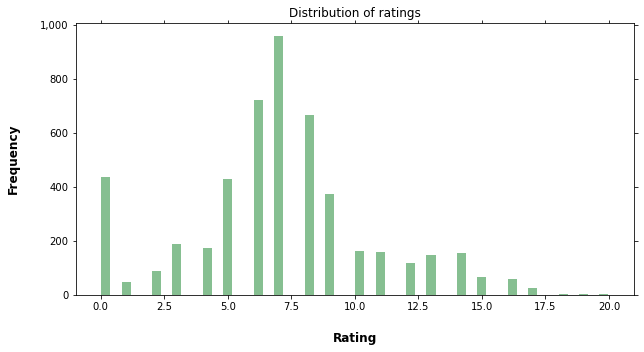

In [14]:
ax = df.hist(column='custom_rating', bins=50, grid=False, figsize=(10,5), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    x.set_title("Distribution of ratings")
    x.set_xlabel("Rating", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

The high number of bonds with a low rating (strong balance sheet) is suspicious. Let's investigate.

In [15]:
pd.set_option('display.max_rows', 50)
pd.DataFrame(df["issuer"].loc[df["custom_rating"] == 0].unique(), columns = ["Issuer"])

Issuer
0                    European Union
1           Societe Generale SFH SA
2   Kreditanstalt fuer Wiederaufbau
3               AXA Bank Europe SCF
4     Landesbank Baden-Wuerttemberg
..                              ...
78                         Borgo AB
79             Barclays Bank UK PLC
80                Nordea Hypotek AB
81       Yorkshire Building Society
82              Swedbank Hypotek AB

[83 rows x 1 columns]

There does not seem to be any problem with the large amount of bonds with a strong rating. 

Finally, I need to create my own "name" for each rating. Even if numerical values may contain more information, I do need to create a text representation for each rating in order to be able to sell my idea and get the attention of bankers that expect that the rating scale should always go from AAA to D. Additionally, as I am approaching the classification from three perspectives - as a classical classification task, a regression task and a ordinal classification task - I need to have good labels for each of the three methods. This numeric representation is good for the regression task.


In [16]:
df

issuer          isin  sp_rating  \
0                               HSBC Holdings PLC  US404280DQ93        6.0   
1                               HSBC Holdings PLC  US404280DS59        8.0   
2                               HSBC Holdings PLC  US404280DR76        6.0   
3              Sudzucker International Finance BV  XS2550868801        9.0   
4                                    Barclays PLC  US06738ECC75        8.0   
...                                           ...           ...        ...   
4995                      Standard Chartered Bank  HK0000854163        4.0   
4996             Credit Agricole Home Loan SFH SA  FR0014007VS7        0.0   
4997  Holding d'Infrastructures de Transport SASU  FR0013298684        9.0   
4998                         Brambles Finance PLC  XS1577950667        7.0   
4999                                      Sky Ltd  XS1321424670        6.0   

      moody_rating  fitch_rating bbg_composite_rating country     bbg_ticker  \
0              6.0           4.0                   A-      GB  BZ977954 Corp   
1              7.0           6.0                 BBB+      GB  BZ977957 Corp   
2              6.0           4.0                   A-      GB  BZ977956 Corp   
3              NaN           NaN                   NR      NL  BZ843109 Corp   
4              8.0           5.0                 BBB+      GB  ZN018163 Corp   
...            ...           ...                  ...     ...            ...   
4995           4.0           NaN                   A+      GB  BW821938 Corp   
4996           0.0           0.0                  AAA      FR  BT573368 Corp   
4997           9.0           8.0                 BBB-      FR  AP971138 Corp   
4998           7.0           NaN                 BBB+      GB  AP138040 Corp   
4999           6.0           6.0                   A-      GB  QJ714831 Corp   

      amount_issued issue_date  total_assets  debt_to_common_equity  \
0      1.795378e+09 2022-03-11  2.957939e+06             234.178439   
1      2.051860e+09 2022-03-11  2.957939e+06             234.178439   
2      2.308342e+09 2022-03-11  2.957939e+06             234.178439   
3      4.000000e+08 2022-10-31  8.441400e+03              94.984488   
4      1.518255e+09 2022-02-11  1.384285e+06             482.479855   
...             ...        ...           ...                    ...   
4995   7.397104e+07 2022-06-06  5.447910e+05             617.491006   
4996   1.250000e+09 2022-01-27  2.073955e+06            1007.720002   
4997   5.000000e+08 2017-11-27  7.736529e+03             389.414840   
4998   5.000000e+08 2017-04-10  1.663952e+03            1629.533982   
4999   5.000000e+08 2015-11-17  2.759050e+05             111.621155   

      i_spread_mid  total_debt_total_capital  currency  adjusted_duration_mid  \
0       227.995529                 66.570527       NaN                    NaN   
1       399.580475                       NaN       NaN                    NaN   
2       301.136169                 66.570527       NaN                    NaN   
3       212.724960                       NaN       NaN                    NaN   
4       259.072906                       NaN       NaN                    NaN   
...            ...                       ...       ...                    ...   
4995           NaN                       NaN       NaN                    NaN   
4996     21.757616                       NaN       NaN                    NaN   
4997     50.626286                 79.564350       NaN                    NaN   
4998     67.331566                       NaN       NaN                    NaN   
4999     44.611172                       NaN       NaN                    NaN   

      maturity_years_from_today  active_bookrunners  custom_rating  
0                           NaN                 NaN              5  
1                           NaN                 NaN              7  
2                           NaN                 NaN              5  
3                           NaN            

In [17]:
# create a mapping schedule for the categorical ratings between categorical and numerical values
class_names = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-','BB+','BB','BB-',
              'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-']
bins = list(range(0,19)) # evenly spaced bins between 1 and 19
d = {'custom_rating_names':class_names,'custom_rating_numbers':bins}
rating_names_numbers_mapping = pd.DataFrame(d, columns=['custom_rating_names','custom_rating_numbers'])

# join mapping with df to convert numeric to categorical
df = pd.merge(df,rating_names_numbers_mapping, left_on='custom_rating',
                 right_on='custom_rating_numbers', how='left')

df[["sp_rating", "moody_rating", "fitch_rating", "bbg_composite_rating", 
    "custom_rating_names","custom_rating_numbers"]]

sp_rating  moody_rating  fitch_rating bbg_composite_rating  \
0           6.0           6.0           4.0                   A-   
1           8.0           7.0           6.0                 BBB+   
2           6.0           6.0           4.0                   A-   
3           9.0           NaN           NaN                   NR   
4           8.0           8.0           5.0                 BBB+   
...         ...           ...           ...                  ...   
4979        4.0           4.0           NaN                   A+   
4980        0.0           0.0           0.0                  AAA   
4981        9.0           9.0           8.0                 BBB-   
4982        7.0           7.0           NaN                 BBB+   
4983        6.0           6.0           6.0                   A-   

     custom_rating_names  custom_rating_numbers  
0                      A                    5.0  
1                   BBB+                    7.0  
2                      A                    5.0  
3                   BBB-                    9.0  
4                   BBB+                    7.0  
...                  ...                    ...  
4979                  A+                    4.0  
4980                 AAA                    0.0  
4981                 BBB                    8.0  
4982                BBB+                    7.0  
4983                  A-                    6.0  

[4984 rows x 6 columns]

The rating is, as expected, very similar to Bloomberg's composite rating that in short does a  similar but not identical calculation

I will remove classes that are too small for any meanigful upsampling at later parts of this project when I will deal with class imbalances.

In [18]:
df['custom_rating_names'].value_counts()

BBB+    958
A-      721
BBB     667
AAA     435
A       430
BBB-    373
AA-     189
A+      174
BB+     162
BB      159
B       154
B+      147
BB-     119
AA       89
B-       66
CCC+     60
AA+      48
CCC      25
CCC-      3
Name: custom_rating_names, dtype: int64

In [19]:
rating_names_numbers_mapping

custom_rating_names  custom_rating_numbers
0                  AAA                      0
1                  AA+                      1
2                   AA                      2
3                  AA-                      3
4                   A+                      4
5                    A                      5
6                   A-                      6
7                 BBB+                      7
8                  BBB                      8
9                 BBB-                      9
10                 BB+                     10
11                  BB                     11
12                 BB-                     12
13                  B+                     13
14                   B                     14
15                  B-                     15
16                CCC+                     16
17                 CCC                     17
18                CCC-                     18

In [20]:
# The three CCC classes will be merged into one class.
df.loc[df.custom_rating_names == "CCC-", 'custom_rating_names'] = "CCC"
df.loc[df.custom_rating_names == "CCC+", 'custom_rating_names'] = "CCC"
df.loc[df.custom_rating_numbers > 16, 'custom_rating_numbers'] = 16

# also removing it in the class_names list
rating_names_numbers_mapping.drop(rating_names_numbers_mapping.tail(3).index,inplace=True) # drop last n rows
new_row = {'custom_rating_names':'CCC', 'custom_rating_numbers':16} #append rating to dataframe
rating_names_numbers_mapping = rating_names_numbers_mapping.append(new_row, ignore_index=True)

Next I create a custom encoding that takes the ordered nature of the ratings into account. This encoding will be used for the ordinal classification. 

A naive approach to estimating these ratings would be to apply standard classification algorithms with one-hot-encoded labels and thereby not capture this pattern. The model will in that case assume that the error of misclassifying an AAA as a AA+ is just as bad as misclassifying AAA as a B.

In [21]:
temp = 0
custom_encoding = []
for i in rating_names_numbers_mapping["custom_rating_numbers"]:
    custom_encoding.append(list(np.concatenate((np.ones(len(
        rating_names_numbers_mapping["custom_rating_numbers"])-temp), np.zeros(temp)),axis=0)))
    temp += 1
custom_encoding = pd.DataFrame(custom_encoding)
custom_encoding.insert(0,'custom_rating_numbers',rating_names_numbers_mapping["custom_rating_numbers"])
custom_encoding

custom_rating_numbers    0    1    2    3    4    5    6    7    8    9  \
0                       0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1                       1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2                       2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3                       3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4                       4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
5                       5  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
6                       6  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
7                       7  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
8                       8  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
9                       9  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
10                     10  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
11                     11  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
12                     12  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
13                     13  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
14                     14  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15                     15  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16                     16  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     10   11   12   13   14   15   16  
0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1   1.0  1.0  1.0  1.0  1.0  1.0  0.0  
2   1.0  1.0  1.0  1.0  1.0  0.0  0.0  
3   1.0  1.0  1.0  1.0  0.0  0.0  0.0  
4   1.0  1.0  1.0  0.0  0.0  0.0  0.0  
5   1.0  1.0  0.0  0.0  0.0  0.0  0.0  
6   1.0  0.0  0.0  0.0  0.0  0.0  0.0  
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0

The encoding proposed above does capture similarities 

In [22]:
df=pd.merge(df,custom_encoding, left_on='custom_rating_numbers', right_on='custom_rating_numbers', how='left')

# removing the other ratings
df = df.drop(['sp_rating', 'moody_rating', 'fitch_rating', 'bbg_composite_rating', 'custom_rating'], axis=1)
df

issuer          isin country  \
0                               HSBC Holdings PLC  US404280DQ93      GB   
1                               HSBC Holdings PLC  US404280DS59      GB   
2                               HSBC Holdings PLC  US404280DR76      GB   
3              Sudzucker International Finance BV  XS2550868801      NL   
4                                    Barclays PLC  US06738ECC75      GB   
...                                           ...           ...     ...   
4979                      Standard Chartered Bank  HK0000854163      GB   
4980             Credit Agricole Home Loan SFH SA  FR0014007VS7      FR   
4981  Holding d'Infrastructures de Transport SASU  FR0013298684      FR   
4982                         Brambles Finance PLC  XS1577950667      GB   
4983                                      Sky Ltd  XS1321424670      GB   

         bbg_ticker  amount_issued issue_date  total_assets  \
0     BZ977954 Corp   1.795378e+09 2022-03-11  2.957939e+06   
1     BZ977957 Corp   2.051860e+09 2022-03-11  2.957939e+06   
2     BZ977956 Corp   2.308342e+09 2022-03-11  2.957939e+06   
3     BZ843109 Corp   4.000000e+08 2022-10-31  8.441400e+03   
4     ZN018163 Corp   1.518255e+09 2022-02-11  1.384285e+06   
...             ...            ...        ...           ...   
4979  BW821938 Corp   7.397104e+07 2022-06-06  5.447910e+05   
4980  BT573368 Corp   1.250000e+09 2022-01-27  2.073955e+06   
4981  AP971138 Corp   5.000000e+08 2017-11-27  7.736529e+03   
4982  AP138040 Corp   5.000000e+08 2017-04-10  1.663952e+03   
4983  QJ714831 Corp   5.000000e+08 2015-11-17  2.759050e+05   

      debt_to_common_equity  i_spread_mid  total_debt_total_capital  ...    7  \
0                234.178439    227.995529                 66.570527  ...  1.0   
1                234.178439    399.580475                       NaN  ...  1.0   
2                234.178439    301.136169                 66.570527  ...  1.0   
3                 94.984488    212.724960                       NaN  ...  1.0   
4                482.479855    259.072906                       NaN  ...  1.0   
...                     ...           ...                       ...  ...  ...   
4979             617.491006           NaN                       NaN  ...  1.0   
4980            1007.720002     21.757616                       NaN  ...  1.0   
4981             389.414840     50.626286                 79.564350  ...  1.0   
4982            1629.533982     67.331566                       NaN  ...  1.0   
4983             111.621155     44.611172                       NaN  ...  1.0   

        8    9   10   11   12   13   14   15   16  
0     1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
1     1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  
4979  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  
4980  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
4981  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4982  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4983  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4984 rows x 33 columns]

Before we can apply methods to deal with the apparent class imbalance we need to clean the dataset and come up with good features.

# Dealing with nulls 

In [23]:
df = df.dropna(axis=1, how='all') # drop all columns where every row is NaN

I use the package Missingno to better understand the distribution of nulls

Missingno Bar plot : The height of the bar indicates how complete that column is, i.e, how many non-null values are present. On the left side of the plot, the y-axis scale ranges from 0.0 
to 1.0, where 1.0 represents 100% data completeness. If the bar is less than this, 
it indicates that we have missing values within that column.

<AxesSubplot:>

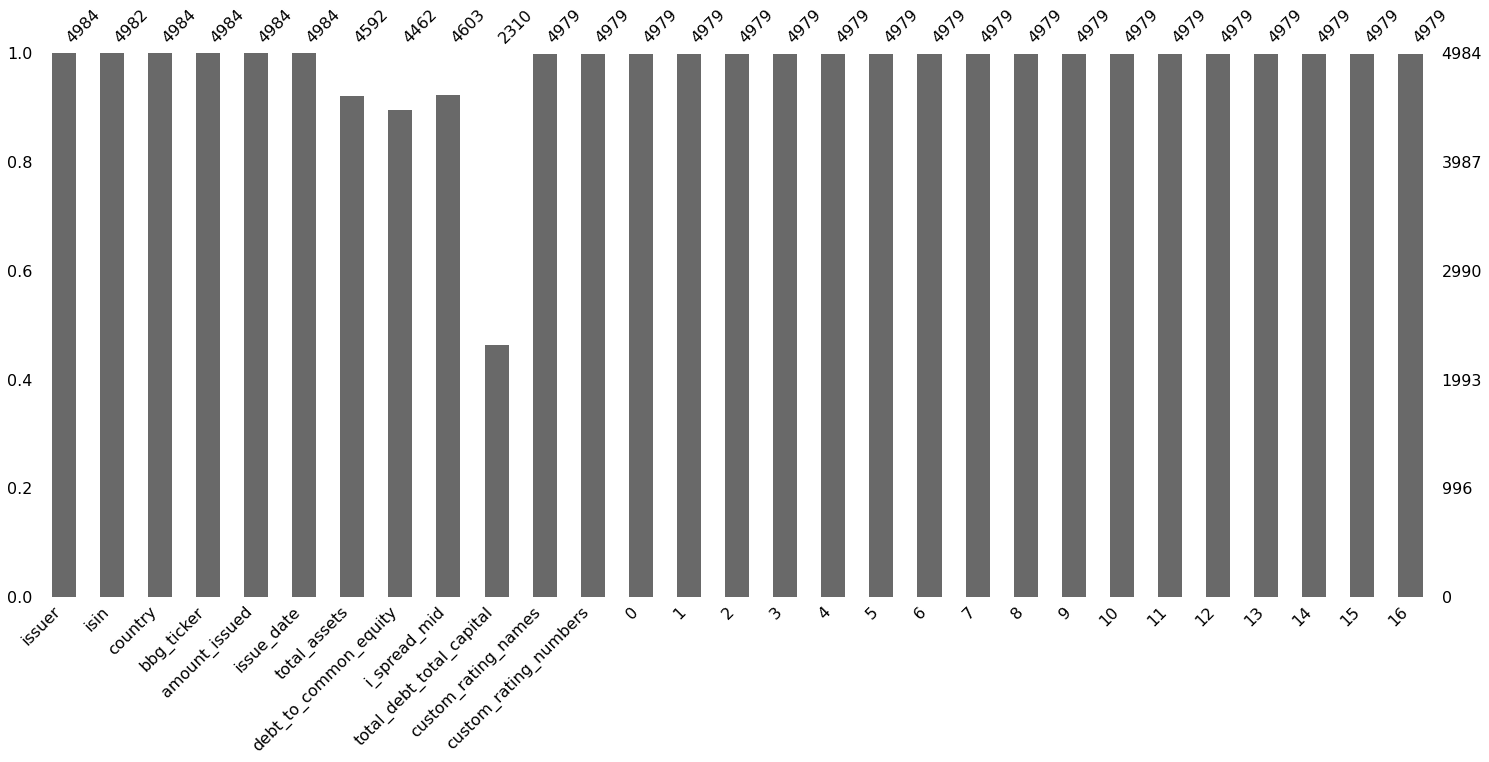

In [24]:
msno.bar(df)

Missingno Matrix plot: When data is present, the plot is shaded in grey (or your colour of choice), and when it is absent the plot is displayed in white. I use it to understand if the errors are
evenly distributed or if some systematic error is causing the nulls to appear.

<AxesSubplot:>

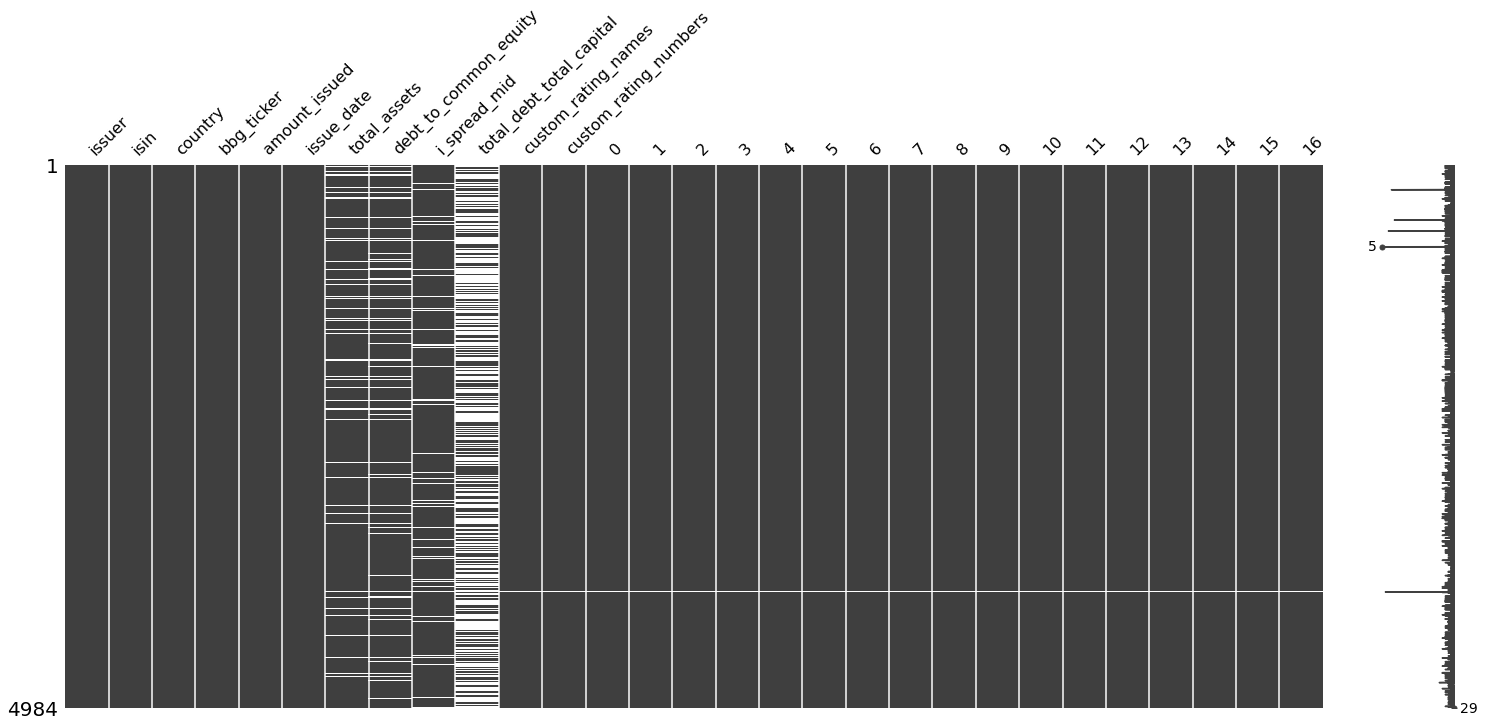

In [25]:
msno.matrix(df)

There are a lot of nulls across multiple columns. The simplest way to deal with nulls is to remove all rows with a null value in any of the columns. This method is infeasible in this case as it would omit a large portion of the dataset. We can also assign the nulls for example the average of that column. A drawbacks with that method is that it does not make use of the relationship between the null value and the other columns. Another drawback is that the common method of doing it would create data leakage. 


I will in the following code instead run an ensemble of decision trees using the random forest algorithm to impute values in one column at a time. For each column, a random forest regressor is trained to predict the missing values in that column based on the values in the other columns. I chose to only include the columns with floats in this model as they are "the closest to being preprocessed" out of all of the columns. These columns are however not ideal as the column values are on vastly different scales. Random forest is however an algorithm that can deal with both values in vastly different scales and outliers somewhat good as opposed to using algorithms like the unsupervised KNN that would otherwise be a good option. If I would have used the KNN, the euclidean distance between two points would not be a good estimator to impute values.

In [26]:
# only feeding the random forest regressor the floats
columns_for_RF = df.select_dtypes(include='float64')
imptr = IterativeImputer(RandomForestRegressor(n_jobs = 12), max_iter=10, random_state=42)
imputed_values = pd.DataFrame(imptr.fit_transform(columns_for_RF), columns = columns_for_RF.columns)

# add imputed values to dataframe
df = df.select_dtypes(exclude=['float64']) # dataframe without numerical data
df = pd.concat([df.reset_index(drop=True), imputed_values], axis = 1)

C:\Users\Erik Konstenius\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Understanding outliers

Next I will look at the distribution of datapoints to see if there are outliers present 
that could have large effect on the final model. Note that some models are more sensitive
to outliers than others

In [27]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) 

amount_issued    total_assets debt_to_common_equity  \
count         4984.00000      4984.00000            4984.00000   
mean     932763963.14181    463007.62224           42607.45374   
std     1123121722.34849   1826292.55726          328808.30448   
min       51460175.00000         0.01269               0.00000   
25%      500000000.00000     21019.10189             128.16940   
50%      699781600.00000     74569.76800             340.64600   
75%     1000000000.00000    550962.00000             623.13570   
max    20000000000.00000  67688771.00000         4484800.00000   

            i_spread_mid total_debt_total_capital custom_rating_numbers  \
count         4984.00000               4984.00000            4984.00000   
mean       6937292.54995                 69.68572               6.95445   
std      356282897.93633                 23.77990               3.62873   
min        -133244.45312                  0.00000               0.00000   
25%             55.76309                 52.57882               5.00000   
50%            151.05113                 75.15590               7.00000   
75%            300.70927                 85.99423               9.00000   
max    21474836480.00000                424.51188              16.00000   

                0           1           2           3  ...           7  \
count  4984.00000  4984.00000  4984.00000  4984.00000  ...  4984.00000   
mean      1.00000     0.98234     0.96910     0.93820  ...     0.82043   
std       0.00000     0.13171     0.17306     0.24081  ...     0.38387   
min       1.00000     0.00000     0.00000     0.00000  ...     0.00000   
25%       1.00000     1.00000     1.00000     1.00000  ...     1.00000   
50%       1.00000     1.00000     1.00000     1.00000  ...     1.00000   
75%       1.00000     1.00000     1.00000     1.00000  ...     1.00000   
max       1.00000     1.00000     1.00000     1.00000  ...     1.00000   

                8           9          10          11          12          13  \
count  4984.00000  4984.00000  4984.00000  4984.00000  4984.00000  4984.00000   
mean      0.74559     0.61176     0.41854     0.27388     0.18760     0.15269   
std       0.43558     0.48740     0.49337     0.44599     0.39043     0.35972   
min       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
25%       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000   
50%       1.00000     1.00000     0.00000     0.00000     0.00000     0.00000   
75%       1.00000     1.00000     1.00000     1.00000     0.00000     0.00000   
max       1.00000     1.00000     1.00000     1.00000     1.00000     1.00000   

               14          15          16  
count  4984.00000  4984.00000  4984.00000  
mean      0.11477     0.09691     0.08728  
std       0.31877     0.29587     0.28227  
min       0.00000     0.00000     0.00000  
25%       0.00000     0.00000     0.00000  
50%       0.00000     0.00000     0.00000  
75%       0.00000     0.00000     0.00000  
max       1.00000     1.00000     1.00000  

[8 rows x 23 columns]

In [28]:
fig = px.box(df[['amount_issued','total_assets','debt_to_common_equity','i_spread_mid',
                 'total_debt_total_capital', 'custom_rating_numbers']].melt(),
             y="value", facet_col="variable", boxmode="overlay", color="variable")
fig.update_yaxes(matches=None)

for i in range(len(fig["data"])):
    yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
    fig.layout[yaxis_name].showticklabels = True

fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

fig.update_layout(
    title='Box plot for each column',
    dragmode='select',
    width=1800,
    height=400,
)

fig.show()

The data appears to have quite extreme outliers. I will classify the highest 5 percent in the columns "amount_issued", "total_assets", "debt_to_common_equity" and "i_spread_mid" as too extreme to be accepted in the training phase. That means that an observation will be deleted if a value in any of the four columns exceeds the limit of what is acceptable. I will also remove the 1 % lowest values in the column "i_spread_mid"

In [29]:
print("Number of observations before removing outliers: " + str(len(df)))

Number of observations before removing outliers: 4984


In [30]:
df = df[(df["amount_issued"] < df["amount_issued"].quantile(0.98)) &
        (df["total_assets"] < df["total_assets"].quantile(0.98)) &
        (df["debt_to_common_equity"] < df["debt_to_common_equity"].quantile(0.98)) &
        (df["i_spread_mid"] < df["i_spread_mid"].quantile(0.98)) &
        (df["i_spread_mid"] > df["i_spread_mid"].quantile(0.01))] 

In [31]:
print("Number of observations after removing outliers: " + str(len(df)))

Number of observations after removing outliers: 4508


In [32]:
# scatterplot matrix of numerical columns
fig = px.scatter_matrix(df,
    dimensions=['amount_issued','total_assets','debt_to_common_equity','i_spread_mid',
                 'total_debt_total_capital', 'custom_rating_numbers'], # gets all numerical cols
    color="custom_rating_numbers", color_continuous_scale=px.colors.sequential.Magma)

fig.update_layout(
    title='Feature scatterplot matrix',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',
)
fig.show()

Not sure what clever conclusions can be drawn from the figure above. Somewhat difficult to create a fair representation of a rather high dimensional data set.

# Feature engineering

A date variable could be important in this case considering that the risk sentiment of a particular bonds is expected to correlate strongly to the economic environment. But it is important to represent the date value in a meaningful way. Without proper preprocessing, a date would never be considered by a ML model

In [33]:
df['year_issuedate'] = pd.DatetimeIndex(df['issue_date']).year # extract year 
df = df.drop(['issue_date'], axis=1)

C:\Users\Erik Konstenius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



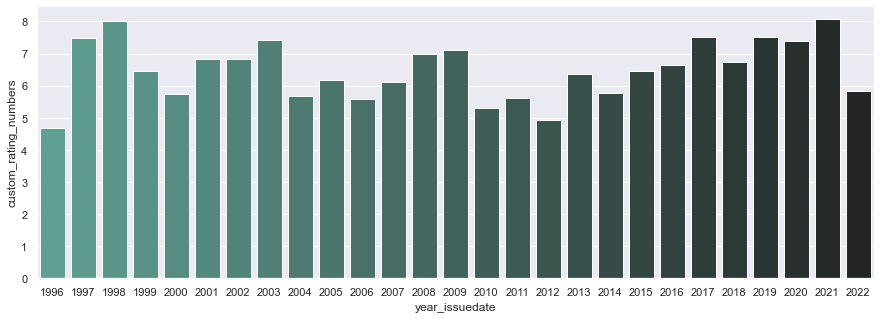

In [34]:
sns.set(rc={'figure.figsize':(15,5)})
p = sns.barplot('year_issuedate', 'custom_rating_numbers', data=df, ci=False, palette = 'dark:#5A9_r')

Next, I use the country of origin column to create dummary variables based on the region they are situated in. The motivation is that I believe that companies are on average higher rated if they originate from countries like Denmark, Norway and Germany. I found a dataset on kaggle that maps the alpha-2 country code to a sub-region. I join this dataset with my original dataframe.

In [35]:
region_mapping = pd.read_csv(r"C:\Users\Erik Konstenius\OneDrive\Skrivbord\QRM\continents.csv")
region_mapping = region_mapping[["alpha-2", "sub-region"]]
region_mapping

alpha-2          sub-region
0        AF       Southern Asia
1        AX     Northern Europe
2        AL     Southern Europe
3        DZ     Northern Africa
4        AS           Polynesia
..      ...                 ...
244      WF           Polynesia
245      EH     Northern Africa
246      YE        Western Asia
247      ZM  Sub-Saharan Africa
248      ZW  Sub-Saharan Africa

[249 rows x 2 columns]

Merge region_mapping with main df

In [36]:
df = df.merge(region_mapping, left_on='country', right_on='alpha-2')
df["sub-region"].value_counts()

Western Europe                     2435
Northern Europe                    1275
Southern Europe                     586
Northern America                    193
Eastern Europe                        7
Australia and New Zealand             5
Latin America and the Caribbean       4
Sub-Saharan Africa                    1
Eastern Asia                          1
South-eastern Asia                    1
Name: sub-region, dtype: int64

Removing regions with few observations

In [37]:
df = df[(df["sub-region"] != 'Eastern Europe') & 
        (df["sub-region"] != 'Australia and New Zealand') &
        (df["sub-region"] != 'Latin America and the Caribbean') &
        (df["sub-region"] != 'Sub-Saharan Africa') &
        (df["sub-region"] != 'South-eastern Asia') &
        (df["sub-region"] != 'Eastern Asia')]

C:\Users\Erik Konstenius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



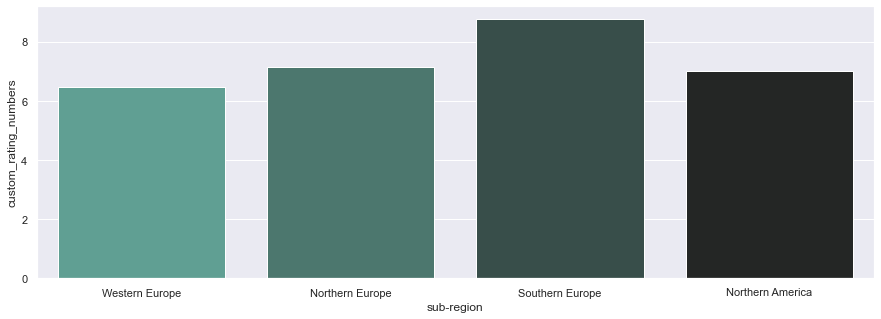

In [38]:
sns.set(rc={'figure.figsize':(15,5)})
p = sns.barplot('sub-region', 'custom_rating_numbers', data=df, ci=False, palette = 'dark:#5A9_r')

The credit ratings appears to be worse for bonds issued by companies originating from countries in Southern Europe and better for bonds whos issuer originates in Western Europe

In [39]:
# convert sub-region to dummy variables
label_binarizer = LabelBinarizer()
label_binarizer_output = label_binarizer.fit_transform(df['sub-region'])
dummy_variables = pd.DataFrame(label_binarizer_output,columns = label_binarizer.classes_)

# add dummy variable dataframe to main dataframe
df = pd.concat([df.reset_index(drop=True), dummy_variables], axis = 1) 

# drop the columns "country", "isin", "bbg_ticker", "alpha-2", "sub-region"
df = df.drop(["country", "alpha-2", "sub-region"], axis=1)

In [40]:
df

issuer          isin     bbg_ticker  \
0           Sudzucker International Finance BV  XS2550868801  BZ843109 Corp   
1                     Cooperatieve Rabobank UA  XS2550081454  BZ869751 Corp   
2                            TenneT Holding BV  XS2549715618  BZ841890 Corp   
3          Volkswagen International Finance NV  XS2554487905  ZN213982 Corp   
4                                 ING Groep NV  XS2554746185  ZN213539 Corp   
...                                        ...           ...            ...   
4484                      VW Credit Canada Inc  CA918423AX21  ZO517193 Corp   
4485                      VW Credit Canada Inc  CA918423AY04  ZO517194 Corp   
4486                     Summit Properties Ltd  XS1757821688  AQ787317 Corp   
4487  Credit Suisse Group Funding Guernsey Ltd  XS1317432620  QJ714936 Corp   
4488                  Swiss Life Finance I Ltd  CH1210198136  BY577550 Corp   

     custom_rating_names  amount_issued  total_assets  debt_to_common_equity  \
0                   BBB-   4.000000e+08      8441.400              94.984488   
1                      A   1.000000e+09    639575.000             452.179487   
2                     A-   8.500000e+08     31200.000             292.588770   
3                     A-   1.000000e+09     31268.700            8395.147512   
4                      A   1.250000e+09    951290.000             377.237657   
...                  ...            ...           ...                    ...   
4484                  A-   3.206315e+08    528609.000             161.680640   
4485                  A-   3.206315e+08    528609.000             161.680640   
4486                BBB-   3.000000e+08      1765.419              64.696942   
4487                 BBB   1.800000e+08    755833.000             614.908768   
4488                  A-   7.000000e+08    240424.000              27.468684   

      i_spread_mid  total_debt_total_capital  custom_rating_numbers  ...   12  \
0       212.724960                 45.631406                    9.0  ...  0.0   
1       138.645844                 81.716775                    5.0  ...  0.0   
2       144.058609                 65.073462                    6.0  ...  0.0   
3        92.595665                 98.822857                    6.0  ...  0.0   
4       171.970673                 78.820630                    5.0  ...  0.0   
...            ...                       ...                    ...  ...  ...   
4484     72.588120                 58.986404                    6.0  ...  0.0   
4485    136.368958                 58.989842                    6.0  ...  0.0   
4486    614.253845                 36.671717                    9.0  ...  0.0   
4487    356.831130                 85.936720                    8.0  ...  0.0   
4488    160.745941                 22.263977                    6.0  ...  0.0   

       13   14   15   16  year_issuedate  Northern America  Northern Europe  \
0     0.0  0.0  0.0  0.0            2022                 0                0   
1     0.0  0.0  0.0  0.0            2022                 0                0   
2     0.0  0.0  0.0  0.0            2022                 0                0   
3     0.0  0.0  0.0  0.0            2022                 0                0   
4     0.0  0.0  0.0  0.0            2022                 0                0   
...   ...  ...  ...  ...             ...               ...              ...   
4484  0.0  0.0  0.0  0.0            2020                 1                0   
4485  0.0  0.0  0.0  0.0            2020                 1                0   
4486  0.0  0.0  0.0  0.0            2018                 0                1   
4487  0.0  0.0  0.0  0.0            2015                 0                1   
4488  0.0  0.0  0.0  0.0            2022                 0                0   

      Southern Europe  Western Europe  
0                   0               1  
1                   0               1  
2                   0               1  
3                   0               1  
4       

# Standardize features

Algorithms that compute the distance between the features are biased towards numerically larger values if the data is not scaled. Considering that we both have high values like the amount being issued as well as ratios like total debt to the total_capital or the I spread we have datapoints on very different scales.

Tree-based algorithms are fairly insensitive to the scale of the features. Neural networks tend to converge faster as the gradient becomes smoother. I standardize rather than normalize because standardization of the data is not as sensitive to outliers as normalization.

In [41]:
# normalizing the relevant features
data_to_standardize = df[["amount_issued", "total_assets", "debt_to_common_equity", "i_spread_mid",
                          "total_debt_total_capital", "year_issuedate"]]

# fit and transform the data
df_std = pd.DataFrame(StandardScaler().fit_transform(data_to_standardize),
                      columns=data_to_standardize.columns)

# replace previous data with standardized data in original dataframe
df = df.drop(list(df_std.columns), axis=1)
df = pd.concat([df.reset_index(drop=True), df_std], axis = 1)
df

issuer          isin     bbg_ticker  \
0           Sudzucker International Finance BV  XS2550868801  BZ843109 Corp   
1                     Cooperatieve Rabobank UA  XS2550081454  BZ869751 Corp   
2                            TenneT Holding BV  XS2549715618  BZ841890 Corp   
3          Volkswagen International Finance NV  XS2554487905  ZN213982 Corp   
4                                 ING Groep NV  XS2554746185  ZN213539 Corp   
...                                        ...           ...            ...   
4484                      VW Credit Canada Inc  CA918423AX21  ZO517193 Corp   
4485                      VW Credit Canada Inc  CA918423AY04  ZO517194 Corp   
4486                     Summit Properties Ltd  XS1757821688  AQ787317 Corp   
4487  Credit Suisse Group Funding Guernsey Ltd  XS1317432620  QJ714936 Corp   
4488                  Swiss Life Finance I Ltd  CH1210198136  BY577550 Corp   

     custom_rating_names  custom_rating_numbers    0    1    2    3    4  ...  \
0                   BBB-                    9.0  1.0  1.0  1.0  1.0  1.0  ...   
1                      A                    5.0  1.0  1.0  1.0  1.0  1.0  ...   
2                     A-                    6.0  1.0  1.0  1.0  1.0  1.0  ...   
3                     A-                    6.0  1.0  1.0  1.0  1.0  1.0  ...   
4                      A                    5.0  1.0  1.0  1.0  1.0  1.0  ...   
...                  ...                    ...  ...  ...  ...  ...  ...  ...   
4484                  A-                    6.0  1.0  1.0  1.0  1.0  1.0  ...   
4485                  A-                    6.0  1.0  1.0  1.0  1.0  1.0  ...   
4486                BBB-                    9.0  1.0  1.0  1.0  1.0  1.0  ...   
4487                 BBB                    8.0  1.0  1.0  1.0  1.0  1.0  ...   
4488                  A-                    6.0  1.0  1.0  1.0  1.0  1.0  ...   

      Northern America  Northern Europe  Southern Europe  Western Europe  \
0                    0                0                0               1   
1                    0                0                0               1   
2                    0                0                0               1   
3                    0                0                0               1   
4                    0                0                0               1   
...                ...              ...              ...             ...   
4484                 1                0                0               0   
4485                 1                0                0               0   
4486                 0                1                0               0   
4487                 0                1                0               0   
4488                 0                0                0               1   

      amount_issued  total_assets  debt_to_common_equity  i_spread_mid  \
0         -0.706171     -0.595254              -0.164127      0.019193   
1          0.332976      0.531925              -0.142712     -0.323886   
2          0.073189     -0.554608              -0.152280     -0.298818   
3          0.332976     -0.554485               0.333490     -0.537156   
4          0.765954      1.088635              -0.147205     -0.169550   
...             ...           ...                    ...           ...   
4484      -0.843631      0.333744              -0.160128     -0.629816   
4485      -0.843631      0.333744              -0.160128     -0.334430   
4486      -0.879363     -0.607177              -0.165942      1.878774   
4487      -1.087192      0.739557              -0.132956      0.686585   
4488      -0.186598     -0.180942              -0.168174     -0.221535   

      total_debt_total_capital  year_issuedate  
0                    -1.009458        0.898381  
1                     0.623008        0.898381  
2                    -0.129919        0.898381  
3                     1.396870        0.898381  
4                     0.491990        0.898381  
...                   

# Splitting dataset

In [209]:
def splitter(df,classification_type):
    df = df[df['custom_rating_names'].notna()] # if still any null ratings then remove
    features = df.iloc[: , -10:] # remove ratings columns and instrument IDs
    
    if classification_type == "ordinal_classification_custom":
        labels = df[range(0,len(custom_encoding))]  # encoded vectors
        labels = pd.concat([labels, df["custom_rating_numbers"]], axis=1)
    else:
        labels = df[["custom_rating_numbers"]]
    
    # firstly, split data frame into train and test
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2,
                                                    shuffle = True, random_state = 42)    
    # secondly, split train into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125,
                                                    shuffle = True, random_state = 42)
    return X_train, X_test, X_val, y_train, y_val, y_test

# Upsampling using SMOTE

Next step is to upsample each dataframe using SMOTE. The function gets a bit more complicated because I am testing three ways to do classification.

In [210]:
def SMOTE_train_upsampler(X_train, X_test, X_val, y_train, y_val, y_test,rating_names_numbers_mapping, custom_encoding,
                          classification_type):
    temp = y_train # keep record of labels before upsampling
    print("Upsampling training set using SMOTE")
    oversample = SMOTE(k_neighbors=5, n_jobs = 12)
    
    if classification_type == "simple_classification":
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        
    elif classification_type == "regression":
        X_train, y_train = oversample.fit_resample(X_train, y_train.iloc[:,-1:])
    
    elif classification_type == "ordinal_classification_custom":
        X_train, y_train = oversample.fit_resample(X_train, temp.iloc[:,-1:])
        y_train = pd.merge(custom_encoding,y_train, left_on='custom_rating_numbers',
                 right_on='custom_rating_numbers', how='left')

        # shuffle x_train, y_train after SMOTE
        concat = pd.concat([X_train, y_train], axis=1)
        concat = concat.sample(frac=1).reset_index(drop=True)

        X_train = concat[['Northern America', 'Northern Europe', 'Southern Europe',
           'Western Europe', 'amount_issued', 'total_assets',
           'debt_to_common_equity', 'i_spread_mid', 'total_debt_total_capital',
           'year_issuedate']]
        y_train = concat[list(range(0,17))]
    
    return X_train, y_train, y_val, y_test

# Modelling

We feed the features of each dataframe that correspond to one rating vs the rest to the classifier, finds its probability in each prediction and what it actually predicted.

In [240]:
def model_training(model, X_train, X_test, X_val, y_train, y_val, y_test, classification_type):   
    if model == "MLP":
        y_pred, clf = train_MLP(model, X_train, X_test, X_val, y_train, y_val, y_test, classification_type)
    
    else:
        if model == "LREG": # Logistic Regression
            if classification_type == "regression":
                clf = LinearRegression(n_jobs = 12)
        
            elif classification_type == "simple_classification": 
                clf = LogisticRegression(penalty = "l2", max_iter = 500, n_jobs = 12)
        
        elif model == "SVM": # Support Vector Machine
            if classification_type == "regression":
                clf = SVR()
            elif classification_type == "simple_classification": 
                clf = SVC(probability=True, kernel="rbf")
        
        elif model == "RF": # Random Forest
            if classification_type == "regression":
                clf = RandomForestRegressor(n_jobs = 12)
            elif classification_type == "simple_classification": 
                clf = RandomForestClassifier(n_jobs = 12)
        
        elif model == "XGB": # XGBoost
            if classification_type == "regression":
                clf = XGBRegressor(n_jobs = 12)
            elif classification_type == "simple_classification": 
                clf = XGBClassifier(eval_metric = 'mlogloss', use_label_encoder=False, nthread = 12)
        
        elif model == "CATB": # CatBoost
            if classification_type == "regression":
                clf = CatBoostRegressor(verbose=0)
            elif classification_type == "simple_classification": 
                clf = CatBoostClassifier(verbose=0)        
        else:
            return print("Not valid model")
        
        # fit the model
        clf.fit(X_train, y_train.values.ravel())
        
        # Predict the Test set results
        if classification_type == "regression":
            y_pred = np.round(clf.predict(X_val),0)  # need to convert floats to classes
            y_pred[y_pred > 16] = 16 # "CCC" is our lower bound
            y_pred[y_pred < 0] = 0 # "AAA" is our upper bound
            y_pred = pd.DataFrame(np.absolute(y_pred.ravel()), columns = ["custom_rating_numbers"]).astype(str)

        elif classification_type == "simple_classification": 
            y_pred = pd.DataFrame(np.round(clf.predict(X_val),0), columns = ["custom_rating_numbers"]).astype(str)
    
    return y_pred, clf

In [259]:
def train_MLP(model, X_train, X_test, X_val, y_train, y_val, y_test, classification_type):
    # initialisation
    clf = Sequential()

    # Adding the input layer and the first hidden layer
    clf.add(Dense(16, activation = 'relu', input_shape = (len(X_train.columns),)))
    clf.add(BatchNormalization())

    clf.add(Dense(units = 16, activation = 'relu', activity_regularizer=regularizers.L1(1e-4)))
    clf.add(Dense(units = 16, activation = 'relu', activity_regularizer=regularizers.L1(1e-4)))
    # Activity Regularizer: Tries to reduce the layer's output y, thus will reduce the weights 
    # and adjust bias so Wx+b is smallest.
    clf.add(Dense(units = 16, activation = 'relu', activity_regularizer=regularizers.L1(1e-4)))
    clf.add(Dense(units = 16, activation = 'relu', activity_regularizer=regularizers.L1(1e-4)))
    clf.add(BatchNormalization())

    # Adding the output layer 
    # Normally, the output could be like [1 0 1 0 ...]. I add a bias layer to restrict the neural 
    # network to make rank-consistent predictions. You have to make sure that the last layer 
    # shares its weights, but should have different biases. 
    # credits: https://stats.stackexchange.com/questions/140061/how-to-set-up-neural-network-to-output-ordinal-data/324879#324879

    class BiasLayer(tf.keras.layers.Layer):
        def __init__(self, units, *args, **kwargs):
            super(BiasLayer, self).__init__(*args, **kwargs)
            self.bias = self.add_weight('bias',shape=[units],initializer='zeros',trainable=True)
        def call(self, x):
            return x + self.bias

    clf.add(keras.layers.Dense(1, use_bias=False))
    clf.add(BiasLayer(len(y_train.columns))) # the output layer should have same number of neurons
                                             # as the number of classes in the dataset
    clf.add(keras.layers.Activation("sigmoid"))

    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    clf.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    # binary crossentropy as each neuron in output is either 0 or 1
    clf.summary()
    clf.fit(X_train, y_train, batch_size=128, epochs = 15)

    # output is array of size obs * number of classes - need to shape it into array of size obs
    y_pred = np.round(clf.predict(X_val),0).ravel() 
    y_pred = pd.DataFrame(y_pred.reshape((len(y_val), len(y_train.columns))))
    y_pred = pd.merge(y_pred, custom_encoding,
               left_on=list(range(0,len(pd.DataFrame(y_pred).columns))),
               right_on=list(range(0,len(pd.DataFrame(y_pred).columns))), how='left')
    y_pred = pd.DataFrame(y_pred["custom_rating_numbers"].astype(float).astype(int, errors='ignore'))
    y_pred = y_pred.fillna(y_pred['custom_rating_numbers'].value_counts().index[0]) # lazy and bad fix
    return y_pred, clf

In [263]:
def evaluate_models(clf, model, X_train, X_test, X_val, y_train, y_val, y_test, y_pred, classification_type):
    print("------------------------------------------------------------")
    print("Model: " + str(model))
    # Check accuracy score 
    accuracy = round(accuracy_score(y_val["custom_rating_numbers"].astype(float).astype(int),
                                    y_pred["custom_rating_numbers"].astype(float).astype(int)),4)
    print("Accuracy: " + str(accuracy))

    # "weighted": calculate metrics for each label, and find their average weighted by the number of 
    # true instances for each label
    precision = round(precision_score(y_val["custom_rating_numbers"].astype(float).astype(int),
                                      y_pred["custom_rating_numbers"].astype(float).astype(int), 
                                      average='weighted', zero_division=0),4)
    # print("Precision: " + str(precision))

    # "weighted": calculate metrics for each label, and find their average weighted by the number of 
    # true instances for each label
    F1 = round(f1_score(y_val["custom_rating_numbers"].astype(float).astype(int),
                        y_pred["custom_rating_numbers"].astype(float).astype(int),
                        average='weighted', zero_division=0),4)
    # print("F1 Score: " + str(F1))

    # cross validation
    if model != "MLP":
        if ((classification_type == "simple_classification") 
              or (classification_type == "ordinal_classification_default")):
            metric = 'accuracy'
        else:
            metric = 'neg_mean_absolute_error'
            
        cv_scores = np.mean(np.round(np.mean(cross_val_score(clf,
                                X_train, y_train.values.ravel(),
                                cv=5, scoring = metric)),4))
        print("Cross val scores: " + str(cv_scores))
    
    elif model == "MLP":
        cv_scores = "-"
    
    result = {'Model':model,
              'Accuracy': accuracy,
              'Precision': precision,
              'F1': F1,
              'CV_score' : cv_scores}

    return result

In [247]:
def train_models(models, classification_type):
    print("Splitting dataset into train, test, validation")
    
    # split
    X_train, X_test, X_val, y_train, y_val, y_test = splitter(df, classification_type)
    
    # check size
    print("Sizes after split (X,Y)")
    print("Train: " + str(X_train.shape) + "," + str(y_train.shape))
    print("Validation: " + str(X_val.shape) + "," + str(y_val.shape))
    print("Test: " + str(X_test.shape) + "," + str(y_test.shape))
    print("")
    
    # Upsample
    X_train, y_train, y_val, y_test = SMOTE_train_upsampler(X_train, X_test, X_val, y_train, y_val, y_test,rating_names_numbers_mapping,
                                         custom_encoding,classification_type)
    # check size
    print("Train size after upsample:")
    print("Train: " + str(X_train.shape) + ", " + str(y_train.shape))
    
    results = pd.DataFrame(columns=["Model", "Accuracy", "Precision",
                                    "F1", "CV_score"])
    for model in models:
        y_pred, clf = model_training(model, X_train, X_test, X_val, y_train, y_val, y_test, classification_type)
        result = evaluate_models(clf, model, X_train, X_test, X_val, y_train, y_val, y_test, y_pred, classification_type)
        results = results.append(result, ignore_index=True)
    
    results = results.sort_values(by=['CV_score'], ascending = False)
    return results, y_pred, X_train, X_test, X_val, y_train, y_val, y_test

## Training - simple classification

In [226]:
results, y_pred, X_train, X_test, X_val, y_train, y_val, y_test = train_models(models = 
                ["LREG", "SVM", "RF", "XGB", "CATB"], classification_type = "simple_classification")

Splitting dataset into train, test, validation
Sizes after split (X,Y)
Train: (3139, 10),(3139, 1)
Validation: (449, 10),(449, 1)
Test: (898, 10),(898, 1)

Upsampling training set using SMOTE
Train size after upsample:
Train: (10778, 10), (10778, 1)
------------------------------------------------------------
Model: LREG
Accuracy: 0.2918
Cross val scores: 0.3477
------------------------------------------------------------
Model: SVM
Accuracy: 0.4477
Cross val scores: 0.5611
------------------------------------------------------------
Model: RF
Accuracy: 0.7149
Cross val scores: 0.9007
------------------------------------------------------------
Model: XGB
Accuracy: 0.735
Cross val scores: 0.8816


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

------------------------------------------------------------
Model: CATB
Accuracy: 0.6837
Cross val scores: 0.8797


In [227]:
results

Model  Accuracy  Precision      F1  CV_score
2    RF    0.7149     0.7455  0.7252    0.9007
3   XGB    0.7350     0.7714  0.7460    0.8816
4  CATB    0.6837     0.7168  0.6948    0.8797
1   SVM    0.4477     0.5390  0.4629    0.5611
0  LREG    0.2918     0.3526  0.3038    0.3477

## Training - ordinal classification

In [260]:
results, y_pred, X_train, X_test, X_val, y_train, y_val, y_test = train_models(models = ["MLP"], classification_type = "ordinal_classification_custom")

Splitting dataset into train, test, validation
Sizes after split (X,Y)
Train: (3139, 10),(3139, 18)
Validation: (449, 10),(449, 18)
Test: (898, 10),(898, 18)

Upsampling training set using SMOTE
Train size after upsample:
Train: (10778, 10), (10778, 17)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 16)                176       
                                                                 
 batch_normalization_20 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_60 (Dense)            (None, 16)                272       
                                                                 
 dense_61 (Dense)            (None, 16)                272       
                                                               

In [261]:
results

Model  Accuracy  Precision      F1 CV_score
0   MLP    0.1448     0.1848  0.1494        -

## Training - regression

In [264]:
results, y_pred, X_train, X_test, X_val, y_train, y_val, y_test = train_models(models = 
                        ["LREG", "SVM", "RF", "XGB", "CATB"], classification_type = "regression")

Splitting dataset into train, test, validation
Sizes after split (X,Y)
Train: (3139, 10),(3139, 1)
Validation: (449, 10),(449, 1)
Test: (898, 10),(898, 1)

Upsampling training set using SMOTE
Train size after upsample:
Train: (10778, 10), (10778, 1)
------------------------------------------------------------
Model: LREG
Accuracy: 0.196
Cross val scores: -2.3071
------------------------------------------------------------
Model: SVM
Accuracy: 0.2628
Cross val scores: -1.6821
------------------------------------------------------------
Model: RF
Accuracy: 0.4321
Cross val scores: -0.9894
------------------------------------------------------------
Model: XGB
Accuracy: 0.3719
Cross val scores: -1.1469
------------------------------------------------------------
Model: CATB
Accuracy: 0.3519
Cross val scores: -1.1656


In [265]:
results

Model  Accuracy  Precision      F1  CV_score
2    RF    0.4321     0.4873  0.4452   -0.9894
3   XGB    0.3719     0.4341  0.3880   -1.1469
4  CATB    0.3519     0.4158  0.3654   -1.1656
1   SVM    0.2628     0.3585  0.2867   -1.6821
0  LREG    0.1960     0.2830  0.1944   -2.3071

The simple method for classification appears to on average deliver the best results. Out of all models, the random forest and the two boosting models with simple classification appears to produce the best results. Let's hyperparameter tune a random forest classifier and a XGBoost classifier.

# Hyperparameter tuning - Bayesian Optimization

- Traditional methods for hyperparameter tuning like grid search and random search are either computationally expensive or can in the case of random search yield parameters that do not produce satisfactory performance. Traditional methods quickly become obsolete when the parameter space grows large. 


- I will use Bayesian Optimization (BO) to tune the hyperparameters in a more sophisticated manner. BO searches for the best parameters by iteratively building a probabilistic model of the function mapping from hyperparameter values to the objective function. The objective function in the case of classification could be accuracy. The BO algorithm will run until an user-defined maximum trials.


- The BO has been implemented with Optuna. Optuna requires us to define an objective function. The objective function defines the model, trains, tests and evaluates. A Study object can then be called to optimize the objective function to find the best hyperparameters combination. 

## Tuning a random forest classifier

- criterion: The function to measure the quality of a split.

- n_estimators: By building forests with a large number of trees (high number of estimators) we can create a more robust aggregate model with less variance, at the cost of a greater training time.

- max_depth: The maximum depth of the tree - meaning the longest path between the root node and the leaf node. If the number of splits is too low, the model underfits the data and if it is too high the model overfits.

- max_features: This is the number of features to consider when looking for the best split.

- min_samples_leaf: This is the minimum number of samples required to be at a leaf node where the default = 1

- min_sample_split: The minimum number of samples required to split an internal node:where the default = 2

In [268]:
# generate dataset
X_train, X_test, X_val, y_train, y_val, y_test = splitter(df, classification_type = "simple_classification")
X_train, y_train, y_val, y_test = SMOTE_train_upsampler(X_train, X_test, X_val, y_train, y_val, y_test,rating_names_numbers_mapping,
                                         custom_encoding,classification_type = "simple_classification")

Upsampling training set using SMOTE


In [269]:
def objective(trial):
    
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("rf_max_depth", 2, 50, log=True)
    max_features = trial.suggest_float("max_features", 0.1,1)
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1,2,4])
    min_samples_split = trial.suggest_int("min_samples_split", 2,10)
    n_estimators = trial.suggest_int("n_estimators", 80,1200,20)
    
    rf_model = RandomForestClassifier(
            criterion = criterion,
            max_depth = max_depth,
            max_features = max_features,
            min_samples_leaf = min_samples_leaf,
            min_samples_split = min_samples_split,
            n_estimators = n_estimators, n_jobs = 12)
    score = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5).mean()
    return score

In [270]:
study = optuna.create_study(sampler=TPESampler(), direction = "maximize")
study.optimize(objective, n_trials = 40)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-12-10 13:22:59,455] A new study created in memory with name: no-name-555bd3bb-a784-49c6-9b6c-9d6247fa3246
[I 2022-12-10 13:23:08,690] Trial 0 finished with value: 0.8749320517069936 and parameters: {'criterion': 'gini', 'rf_max_depth': 28, 'max_features': 0.6728732545983513, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 700}. Best is trial 0 with value: 0.8749320517069936.
[I 2022-12-10 13:23:13,668] Trial 1 finished with value: 0.3764155499786922 and parameters: {'criterion': 'entropy', 'rf_max_depth': 3, 'max_features': 0.2602209495639851, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 640}. Best is trial 0 with value: 0.8749320517069936.
[I 2022-12-10 13:23:22,241] Trial 2 finished with value: 0.8646343017274407 and parameters: {'criterion': 'entropy', 'rf_max_depth': 16, 'max_features': 0.27173866768483534, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 560}. Best is trial 0 with value: 0.8749320517069936.
[I 2022-12-10 13:23

Best Score:  0.9087977650456935
Best Params: 
  criterion: gini
  rf_max_depth: 34
  max_features: 0.2549808975599457
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200


In [271]:
optuna.visualization.plot_param_importances(study)

## Tuning a XGBoost classifier

In [274]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.4)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.5, 1)
    n_estimators = trial.suggest_int("n_estimators", 100,500, log=True)
    gamma = trial.suggest_int("gamma", 0, 9)

    
    xgb_model = XGBClassifier(
            max_depth = max_depth,
            learning_rate = learning_rate,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            colsample_bylevel = colsample_bylevel,
            n_estimators = n_estimators,
            random_state = 42, n_jobs = 12, use_label_encoder=False, nthread = 12)
    score = cross_val_score(xgb_model, X_train, y_train.values.ravel(), cv=5).mean()
    return score

In [275]:
study = optuna.create_study(sampler=TPESampler(), direction = "maximize")
study.optimize(objective, n_trials = 40)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-12-10 13:34:30,207] A new study created in memory with name: no-name-b5c1409f-ab65-40c5-955e-82e589c778fc


[13:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:35:14,850] Trial 0 finished with value: 0.8983132379718392 and parameters: {'max_depth': 13, 'learning_rate': 0.0692639539831326, 'subsample': 0.8925954854325795, 'colsample_bytree': 0.7007068444443144, 'colsample_bylevel': 0.9351059267063605, 'n_estimators': 148, 'gamma': 4}. Best is trial 0 with value: 0.8983132379718392.


[13:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:35:56,282] Trial 1 finished with value: 0.8934884141380662 and parameters: {'max_depth': 14, 'learning_rate': 0.30031497405442603, 'subsample': 0.6050339183026159, 'colsample_bytree': 0.5532671016693435, 'colsample_bylevel': 0.5763664252094504, 'n_estimators': 299, 'gamma': 9}. Best is trial 0 with value: 0.8983132379718392.


[13:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:36:16,260] Trial 2 finished with value: 0.8882937380816068 and parameters: {'max_depth': 8, 'learning_rate': 0.3696689482099546, 'subsample': 0.9444636931707461, 'colsample_bytree': 0.5120098886706125, 'colsample_bylevel': 0.5400545064175439, 'n_estimators': 111, 'gamma': 4}. Best is trial 0 with value: 0.8983132379718392.


[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:36:41,250] Trial 3 finished with value: 0.8254795122014214 and parameters: {'max_depth': 5, 'learning_rate': 0.0735571045749089, 'subsample': 0.772937883397873, 'colsample_bytree': 0.6969714661103761, 'colsample_bylevel': 0.5212404222498848, 'n_estimators': 163, 'gamma': 9}. Best is trial 0 with value: 0.8983132379718392.


[13:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:36:59,989] Trial 4 finished with value: 0.8837465616915402 and parameters: {'max_depth': 5, 'learning_rate': 0.3024732794470577, 'subsample': 0.9212703597106731, 'colsample_bytree': 0.864520920075291, 'colsample_bylevel': 0.6269614950152715, 'n_estimators': 114, 'gamma': 7}. Best is trial 0 with value: 0.8983132379718392.


[13:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:37:26,206] Trial 5 finished with value: 0.8921895406549035 and parameters: {'max_depth': 14, 'learning_rate': 0.39747588511194787, 'subsample': 0.7742384509510376, 'colsample_bytree': 0.6202030451605819, 'colsample_bylevel': 0.8483365310390931, 'n_estimators': 149, 'gamma': 4}. Best is trial 0 with value: 0.8983132379718392.


[13:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:38:00,475] Trial 6 finished with value: 0.8583240425467803 and parameters: {'max_depth': 11, 'learning_rate': 0.014283778484892345, 'subsample': 0.8946787213896747, 'colsample_bytree': 0.7933908315331181, 'colsample_bylevel': 0.9579503717755384, 'n_estimators': 106, 'gamma': 8}. Best is trial 0 with value: 0.8983132379718392.


[13:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:38:31,935] Trial 7 finished with value: 0.8690864753410329 and parameters: {'max_depth': 3, 'learning_rate': 0.31692007584647175, 'subsample': 0.7884575526316993, 'colsample_bytree': 0.9829827029380613, 'colsample_bylevel': 0.8502577180437819, 'n_estimators': 275, 'gamma': 7}. Best is trial 0 with value: 0.8983132379718392.


[13:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:39:07,474] Trial 8 finished with value: 0.8954371978700782 and parameters: {'max_depth': 11, 'learning_rate': 0.3290684927442829, 'subsample': 0.6966032309071579, 'colsample_bytree': 0.9805809495026734, 'colsample_bylevel': 0.8458399526905112, 'n_estimators': 230, 'gamma': 0}. Best is trial 0 with value: 0.8983132379718392.


[13:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:39:21,864] Trial 9 finished with value: 0.8093350236107941 and parameters: {'max_depth': 3, 'learning_rate': 0.2614155368510248, 'subsample': 0.9129457802807115, 'colsample_bytree': 0.8505598077425978, 'colsample_bylevel': 0.6007378395352081, 'n_estimators': 126, 'gamma': 7}. Best is trial 0 with value: 0.8983132379718392.


[13:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:40:31,014] Trial 10 finished with value: 0.8969212126951603 and parameters: {'max_depth': 11, 'learning_rate': 0.13481128917702084, 'subsample': 0.515168712500623, 'colsample_bytree': 0.6863362348747972, 'colsample_bylevel': 0.9917704038821221, 'n_estimators': 457, 'gamma': 1}. Best is trial 0 with value: 0.8983132379718392.


[13:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:41:43,557] Trial 11 finished with value: 0.8957147592215542 and parameters: {'max_depth': 11, 'learning_rate': 0.15232368903743554, 'subsample': 0.5072625962406224, 'colsample_bytree': 0.6837535972204808, 'colsample_bylevel': 0.9943601617973599, 'n_estimators': 494, 'gamma': 1}. Best is trial 0 with value: 0.8983132379718392.


[13:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:42:57,017] Trial 12 finished with value: 0.9001686546797585 and parameters: {'max_depth': 15, 'learning_rate': 0.1466369951636195, 'subsample': 0.5073670843403655, 'colsample_bytree': 0.719432185652043, 'colsample_bylevel': 0.7365305622056559, 'n_estimators': 488, 'gamma': 2}. Best is trial 12 with value: 0.9001686546797585.


[13:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:43:32,440] Trial 13 finished with value: 0.8973851637258996 and parameters: {'max_depth': 15, 'learning_rate': 0.19823720675101514, 'subsample': 0.668717439881907, 'colsample_bytree': 0.7709605399855571, 'colsample_bylevel': 0.7297517959149635, 'n_estimators': 180, 'gamma': 3}. Best is trial 12 with value: 0.9001686546797585.


[13:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:44:54,644] Trial 14 finished with value: 0.8996121545011171 and parameters: {'max_depth': 13, 'learning_rate': 0.07809148818165666, 'subsample': 0.8434027209780635, 'colsample_bytree': 0.624893057499293, 'colsample_bylevel': 0.7141504568925834, 'n_estimators': 371, 'gamma': 2}. Best is trial 12 with value: 0.9001686546797585.


[13:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:46:13,290] Trial 15 finished with value: 0.9005400135164802 and parameters: {'max_depth': 13, 'learning_rate': 0.08817472469439706, 'subsample': 0.8406059934138042, 'colsample_bytree': 0.6085262740697869, 'colsample_bylevel': 0.7054255353658959, 'n_estimators': 377, 'gamma': 2}. Best is trial 15 with value: 0.9005400135164802.


[13:46:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:47:09,613] Trial 16 finished with value: 0.8980346435135962 and parameters: {'max_depth': 9, 'learning_rate': 0.14907647773588126, 'subsample': 0.5909680330684067, 'colsample_bytree': 0.6026983712139472, 'colsample_bylevel': 0.6698194435953929, 'n_estimators': 352, 'gamma': 2}. Best is trial 15 with value: 0.9005400135164802.


[13:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:48:06,577] Trial 17 finished with value: 0.893024333968981 and parameters: {'max_depth': 15, 'learning_rate': 0.2109354610937454, 'subsample': 0.6820989886636141, 'colsample_bytree': 0.5719115853514243, 'colsample_bylevel': 0.7833678066419614, 'n_estimators': 377, 'gamma': 5}. Best is trial 15 with value: 0.9005400135164802.


[13:48:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:50:09,021] Trial 18 finished with value: 0.9005399704703649 and parameters: {'max_depth': 13, 'learning_rate': 0.027237914458919946, 'subsample': 0.8547282414932653, 'colsample_bytree': 0.8284052060398304, 'colsample_bylevel': 0.7802964230655796, 'n_estimators': 448, 'gamma': 0}. Best is trial 15 with value: 0.9005400135164802.


[13:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:51:28,765] Trial 19 finished with value: 0.8757671893899935 and parameters: {'max_depth': 9, 'learning_rate': 0.021047294435750943, 'subsample': 0.9961330313092088, 'colsample_bytree': 0.9018040881154037, 'colsample_bylevel': 0.7898728513860209, 'n_estimators': 296, 'gamma': 0}. Best is trial 15 with value: 0.9005400135164802.


[13:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:52:46,706] Trial 20 finished with value: 0.9011895793964074 and parameters: {'max_depth': 12, 'learning_rate': 0.10575131920754358, 'subsample': 0.8496294748311523, 'colsample_bytree': 0.8053178495259697, 'colsample_bylevel': 0.6714434799439442, 'n_estimators': 417, 'gamma': 1}. Best is trial 20 with value: 0.9011895793964074.


[13:52:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:54:05,019] Trial 21 finished with value: 0.9030446947815195 and parameters: {'max_depth': 12, 'learning_rate': 0.10185356291403447, 'subsample': 0.8319341026069389, 'colsample_bytree': 0.8159812590843086, 'colsample_bylevel': 0.6614948025038752, 'n_estimators': 419, 'gamma': 1}. Best is trial 21 with value: 0.9030446947815195.


[13:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:55:18,674] Trial 22 finished with value: 0.9027667890611213 and parameters: {'max_depth': 12, 'learning_rate': 0.11069273623016584, 'subsample': 0.8259943753112533, 'colsample_bytree': 0.9012088096903541, 'colsample_bylevel': 0.6727456071713928, 'n_estimators': 405, 'gamma': 1}. Best is trial 21 with value: 0.9030446947815195.


[13:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:55:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:56:33,458] Trial 23 finished with value: 0.9024881085106475 and parameters: {'max_depth': 10, 'learning_rate': 0.11302855517512224, 'subsample': 0.8192664847279911, 'colsample_bytree': 0.8972389472125255, 'colsample_bylevel': 0.6693934123468112, 'n_estimators': 424, 'gamma': 1}. Best is trial 21 with value: 0.9030446947815195.


[13:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:57:27,429] Trial 24 finished with value: 0.9017462087133946 and parameters: {'max_depth': 10, 'learning_rate': 0.194730415585189, 'subsample': 0.8102566222067743, 'colsample_bytree': 0.9274740266587568, 'colsample_bylevel': 0.6480698301369567, 'n_estimators': 337, 'gamma': 3}. Best is trial 21 with value: 0.9030446947815195.


[13:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:58:11,505] Trial 25 finished with value: 0.8966433930669927 and parameters: {'max_depth': 7, 'learning_rate': 0.11821424823898015, 'subsample': 0.7331094282486357, 'colsample_bytree': 0.9252776396769166, 'colsample_bylevel': 0.5858162921769876, 'n_estimators': 230, 'gamma': 1}. Best is trial 21 with value: 0.9030446947815195.


[13:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 13:59:26,195] Trial 26 finished with value: 0.8997979845808814 and parameters: {'max_depth': 10, 'learning_rate': 0.047257413640712675, 'subsample': 0.7229790333285162, 'colsample_bytree': 0.8664970917963113, 'colsample_bylevel': 0.6846355785610396, 'n_estimators': 320, 'gamma': 3}. Best is trial 21 with value: 0.9030446947815195.


[13:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:00:14,470] Trial 27 finished with value: 0.8988695229199042 and parameters: {'max_depth': 7, 'learning_rate': 0.1702967248602753, 'subsample': 0.8058848986350077, 'colsample_bytree': 0.8971611879464308, 'colsample_bylevel': 0.6398609484314033, 'n_estimators': 264, 'gamma': 5}. Best is trial 21 with value: 0.9030446947815195.


[14:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:01:19,898] Trial 28 finished with value: 0.900911243214856 and parameters: {'max_depth': 12, 'learning_rate': 0.238380546990715, 'subsample': 0.9756390368959368, 'colsample_bytree': 0.960918055022646, 'colsample_bylevel': 0.558409319768182, 'n_estimators': 422, 'gamma': 0}. Best is trial 21 with value: 0.9030446947815195.


[14:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:02:52,597] Trial 29 finished with value: 0.9034161827565871 and parameters: {'max_depth': 12, 'learning_rate': 0.058475365227257325, 'subsample': 0.868201527243636, 'colsample_bytree': 0.7342616467815654, 'colsample_bylevel': 0.6165600630915414, 'n_estimators': 405, 'gamma': 1}. Best is trial 29 with value: 0.9034161827565871.


[14:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:03:46,997] Trial 30 finished with value: 0.8961799585896371 and parameters: {'max_depth': 12, 'learning_rate': 0.05394582697812809, 'subsample': 0.8714776089583376, 'colsample_bytree': 0.7333351629787115, 'colsample_bylevel': 0.5017119477640976, 'n_estimators': 208, 'gamma': 3}. Best is trial 29 with value: 0.9034161827565871.


[14:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:05:00,101] Trial 31 finished with value: 0.9030448239198654 and parameters: {'max_depth': 10, 'learning_rate': 0.10936183738902325, 'subsample': 0.8162288135804403, 'colsample_bytree': 0.7559648017631481, 'colsample_bylevel': 0.6157253577698629, 'n_estimators': 402, 'gamma': 1}. Best is trial 29 with value: 0.9034161827565871.


[14:05:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:06:20,287] Trial 32 finished with value: 0.9036945619842538 and parameters: {'max_depth': 12, 'learning_rate': 0.09540241041457911, 'subsample': 0.8841309472134748, 'colsample_bytree': 0.7668624687492168, 'colsample_bylevel': 0.6068465007022897, 'n_estimators': 404, 'gamma': 2}. Best is trial 32 with value: 0.9036945619842538.


[14:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:07:42,892] Trial 33 finished with value: 0.900632648756613 and parameters: {'max_depth': 14, 'learning_rate': 0.049018709591487325, 'subsample': 0.8773967185956557, 'colsample_bytree': 0.7589942327188915, 'colsample_bylevel': 0.6087431875802998, 'n_estimators': 319, 'gamma': 2}. Best is trial 32 with value: 0.9036945619842538.


[14:07:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:08:37,212] Trial 34 finished with value: 0.896736544860509 and parameters: {'max_depth': 8, 'learning_rate': 0.08647349259152437, 'subsample': 0.9361392464955167, 'colsample_bytree': 0.7894934099059372, 'colsample_bylevel': 0.5506659277219005, 'n_estimators': 266, 'gamma': 0}. Best is trial 32 with value: 0.9036945619842538.


[14:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:10:11,352] Trial 35 finished with value: 0.9016539178421844 and parameters: {'max_depth': 14, 'learning_rate': 0.05368399809215761, 'subsample': 0.8967301454408172, 'colsample_bytree': 0.6560990679526099, 'colsample_bylevel': 0.6208429053495791, 'n_estimators': 379, 'gamma': 2}. Best is trial 32 with value: 0.9036945619842538.


[14:10:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:11:26,401] Trial 36 finished with value: 0.900818564928608 and parameters: {'max_depth': 10, 'learning_rate': 0.17330019448320594, 'subsample': 0.9586768720376485, 'colsample_bytree': 0.7498418599412433, 'colsample_bylevel': 0.5866770903589669, 'n_estimators': 458, 'gamma': 1}. Best is trial 32 with value: 0.9036945619842538.


[14:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:12:27,534] Trial 37 finished with value: 0.902767047337813 and parameters: {'max_depth': 12, 'learning_rate': 0.09703683118141168, 'subsample': 0.7726578835056195, 'colsample_bytree': 0.824901733523828, 'colsample_bylevel': 0.5656982211054453, 'n_estimators': 293, 'gamma': 3}. Best is trial 32 with value: 0.9036945619842538.


[14:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:13:36,378] Trial 38 finished with value: 0.900633079217766 and parameters: {'max_depth': 11, 'learning_rate': 0.12562003942543193, 'subsample': 0.9219672252337854, 'colsample_bytree': 0.7060960426225478, 'colsample_bylevel': 0.5314680482696135, 'n_estimators': 343, 'gamma': 4}. Best is trial 32 with value: 0.9036945619842538.


[14:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[I 2022-12-10 14:15:14,854] Trial 39 finished with value: 0.9040658777748602 and parameters: {'max_depth': 13, 'learning_rate': 0.06836078191585397, 'subsample': 0.7675996766269387, 'colsample_bytree': 0.7798312956863577, 'colsample_bylevel': 0.6385687435285338, 'n_estimators': 495, 'gamma': 0}. Best is trial 39 with value: 0.9040658777748602.


Best Score:  0.9040658777748602
Best Params: 
  max_depth: 13
  learning_rate: 0.06836078191585397
  subsample: 0.7675996766269387
  colsample_bytree: 0.7798312956863577
  colsample_bylevel: 0.6385687435285338
  n_estimators: 495
  gamma: 0


In [276]:
optuna.visualization.plot_param_importances(study)

## Generate prediction on test set with tuned random forest

In [280]:
# create classifier with best parameters
clf = RandomForestClassifier(criterion = "gini", max_depth = 34, max_features = 0.2549808975599457,
                             min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200,
                             n_jobs = 12)
clf.fit(X_train, y_train.values.ravel())

# generate predictions on test set
y_pred = pd.DataFrame(np.round(clf.predict(X_test),0).ravel(), columns = ["custom_rating_numbers"])
# evaluate model
accuracy = round(accuracy_score(y_test["custom_rating_numbers"], y_pred),4)
print("Accuracy: " + str(accuracy))
precision = round(precision_score(y_test["custom_rating_numbers"], y_pred, average='weighted'),4)
print("Precision: " + str(precision))

F1 = round(f1_score(y_test["custom_rating_numbers"], y_pred, average='weighted'),4)
print("F1 Score: " + str(F1))

cv_scores = np.round(np.mean(cross_val_score(clf, X_train, y_train.values.ravel(), cv=5)),4)
print("Cross val scores: " + str(cv_scores))

Accuracy: 0.7149
Precision: 0.7268
F1 Score: 0.7186
Cross val scores: 0.9071


The accuracy of the tuned classifier on the test set is 62.92 %. The tuning had limited effect on the final output. Next I look at what type of predictions it made. I think the following visualization is better than a large confusion matrix when the classification is between many classes.

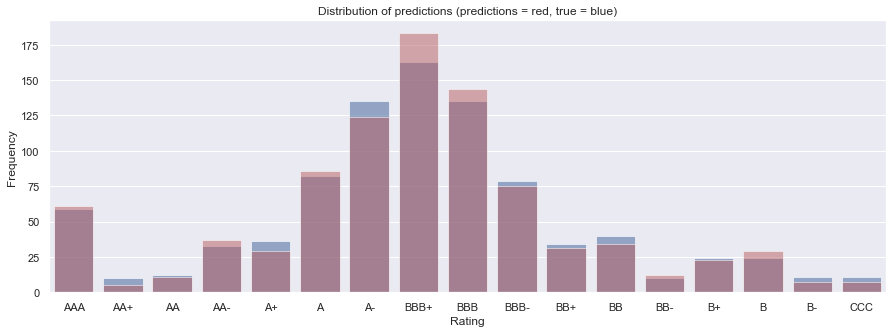

In [281]:
ax = plt.subplots()
unique, counts = np.unique(y_pred["custom_rating_numbers"].values.ravel(), return_counts=True)
ax = sns.barplot(x=list(dict(zip(unique, counts)).keys()),
                 y=list(dict(zip(unique, counts)).values()), color='b', alpha= 0.6)

unique, counts = np.unique(y_test["custom_rating_numbers"], return_counts=True)
ax = sns.barplot(x=list(dict(zip(unique, counts)).keys()),
                 y=list(dict(zip(unique, counts)).values()), color='r', alpha= 0.5)
  
ax.set(xlabel="Rating", ylabel="Frequency")

ax.set_xticklabels(list(rating_names_numbers_mapping["custom_rating_names"]))
plt.title("Distribution of predictions (predictions = red, true = blue)")
plt.show()

# red = predictions
# blue = true

In [282]:
report = classification_report(y_test, y_pred, labels=list(dict(zip(unique, counts)).keys()), target_names=list(rating_names_numbers_mapping["custom_rating_names"]))
print(report)

              precision    recall  f1-score   support

         AAA       0.97      0.93      0.95        61
         AA+       0.20      0.40      0.27         5
          AA       0.58      0.64      0.61        11
         AA-       0.85      0.76      0.80        37
          A+       0.61      0.76      0.68        29
           A       0.77      0.73      0.75        86
          A-       0.76      0.82      0.79       124
        BBB+       0.82      0.73      0.77       183
         BBB       0.79      0.74      0.76       144
        BBB-       0.53      0.56      0.55        75
         BB+       0.65      0.71      0.68        31
          BB       0.55      0.65      0.59        34
         BB-       0.40      0.33      0.36        12
          B+       0.42      0.43      0.43        23
           B       0.58      0.48      0.53        29
          B-       0.27      0.43      0.33         7
         CCC       0.45      0.71      0.56         7

    accuracy              

<AxesSubplot:>

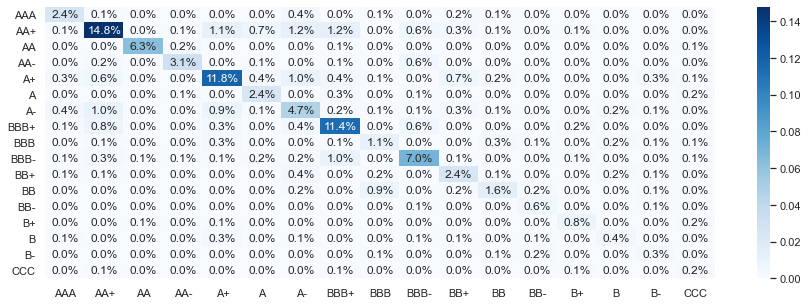

In [283]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = pd.merge(y_test, rating_names_numbers_mapping,
               left_on= y_test['custom_rating_numbers'],
               right_on=rating_names_numbers_mapping['custom_rating_numbers'], how='left')

y_pred = pd.merge(y_pred, rating_names_numbers_mapping,
               left_on= y_pred['custom_rating_numbers'],
               right_on=rating_names_numbers_mapping['custom_rating_numbers'], how='left')

cm = confusion_matrix(y_test["custom_rating_names"], y_pred["custom_rating_names"]
                      , labels =  list(y_test["custom_rating_names"].unique()))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues', 
            xticklabels =  list(rating_names_numbers_mapping["custom_rating_names"]),
            yticklabels =  list(rating_names_numbers_mapping["custom_rating_names"]))

## Generate prediction on test set with tuned XGBoost

In [277]:
# create classifier with best parameters
clf = XGBClassifier(
            max_depth = 13, learning_rate = 0.06836078191585397,
            subsample = 0.7675996766269387, colsample_bytree = 0.7798312956863577,
            colsample_bylevel = 0.6385687435285338, n_estimators = 495,
            gamma = 0, random_state = 42, n_jobs = 12, use_label_encoder=False, nthread = 12)
clf.fit(X_train, y_train.values.ravel())

# generate predictions on test set
y_pred = pd.DataFrame(np.round(clf.predict(X_test),0).ravel(), columns = ["custom_rating_numbers"])
# evaluate model
accuracy = round(accuracy_score(y_test["custom_rating_numbers"], y_pred),4)
print("Accuracy: " + str(accuracy))
precision = round(precision_score(y_test["custom_rating_numbers"], y_pred, average='weighted'),4)
print("Precision: " + str(precision))

F1 = round(f1_score(y_test["custom_rating_numbers"], y_pred, average='weighted'),4)
print("F1 Score: " + str(F1))

cv_scores = np.round(np.mean(cross_val_score(clf, X_train, y_train.values.ravel(), cv=5)),4)
print("Cross val scores: " + str(cv_scores))

[15:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7261
Precision: 0.7375
F1 Score: 0.7293
[15:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:15] WARN

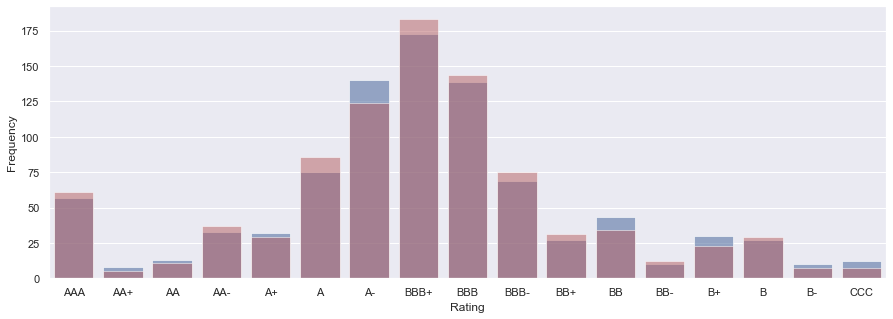

In [279]:
ax = plt.subplots()
unique, counts = np.unique(y_pred["custom_rating_numbers"].values.ravel(), return_counts=True)
ax = sns.barplot(x=list(dict(zip(unique, counts)).keys()),
                 y=list(dict(zip(unique, counts)).values()), color='b', alpha= 0.6)

unique, counts = np.unique(y_test["custom_rating_numbers"], return_counts=True)
ax = sns.barplot(x=list(dict(zip(unique, counts)).keys()),
                 y=list(dict(zip(unique, counts)).values()), color='r', alpha= 0.5)
  
ax.set(xlabel="Rating", ylabel="Frequency")

ax.set_xticklabels(list(rating_names_numbers_mapping["custom_rating_names"]))

plt.show()

# red = predictions
# blue = true

## Explainability of final model

### Global explainability

Text(0.5, 0, 'Random Forest Feature Importance')

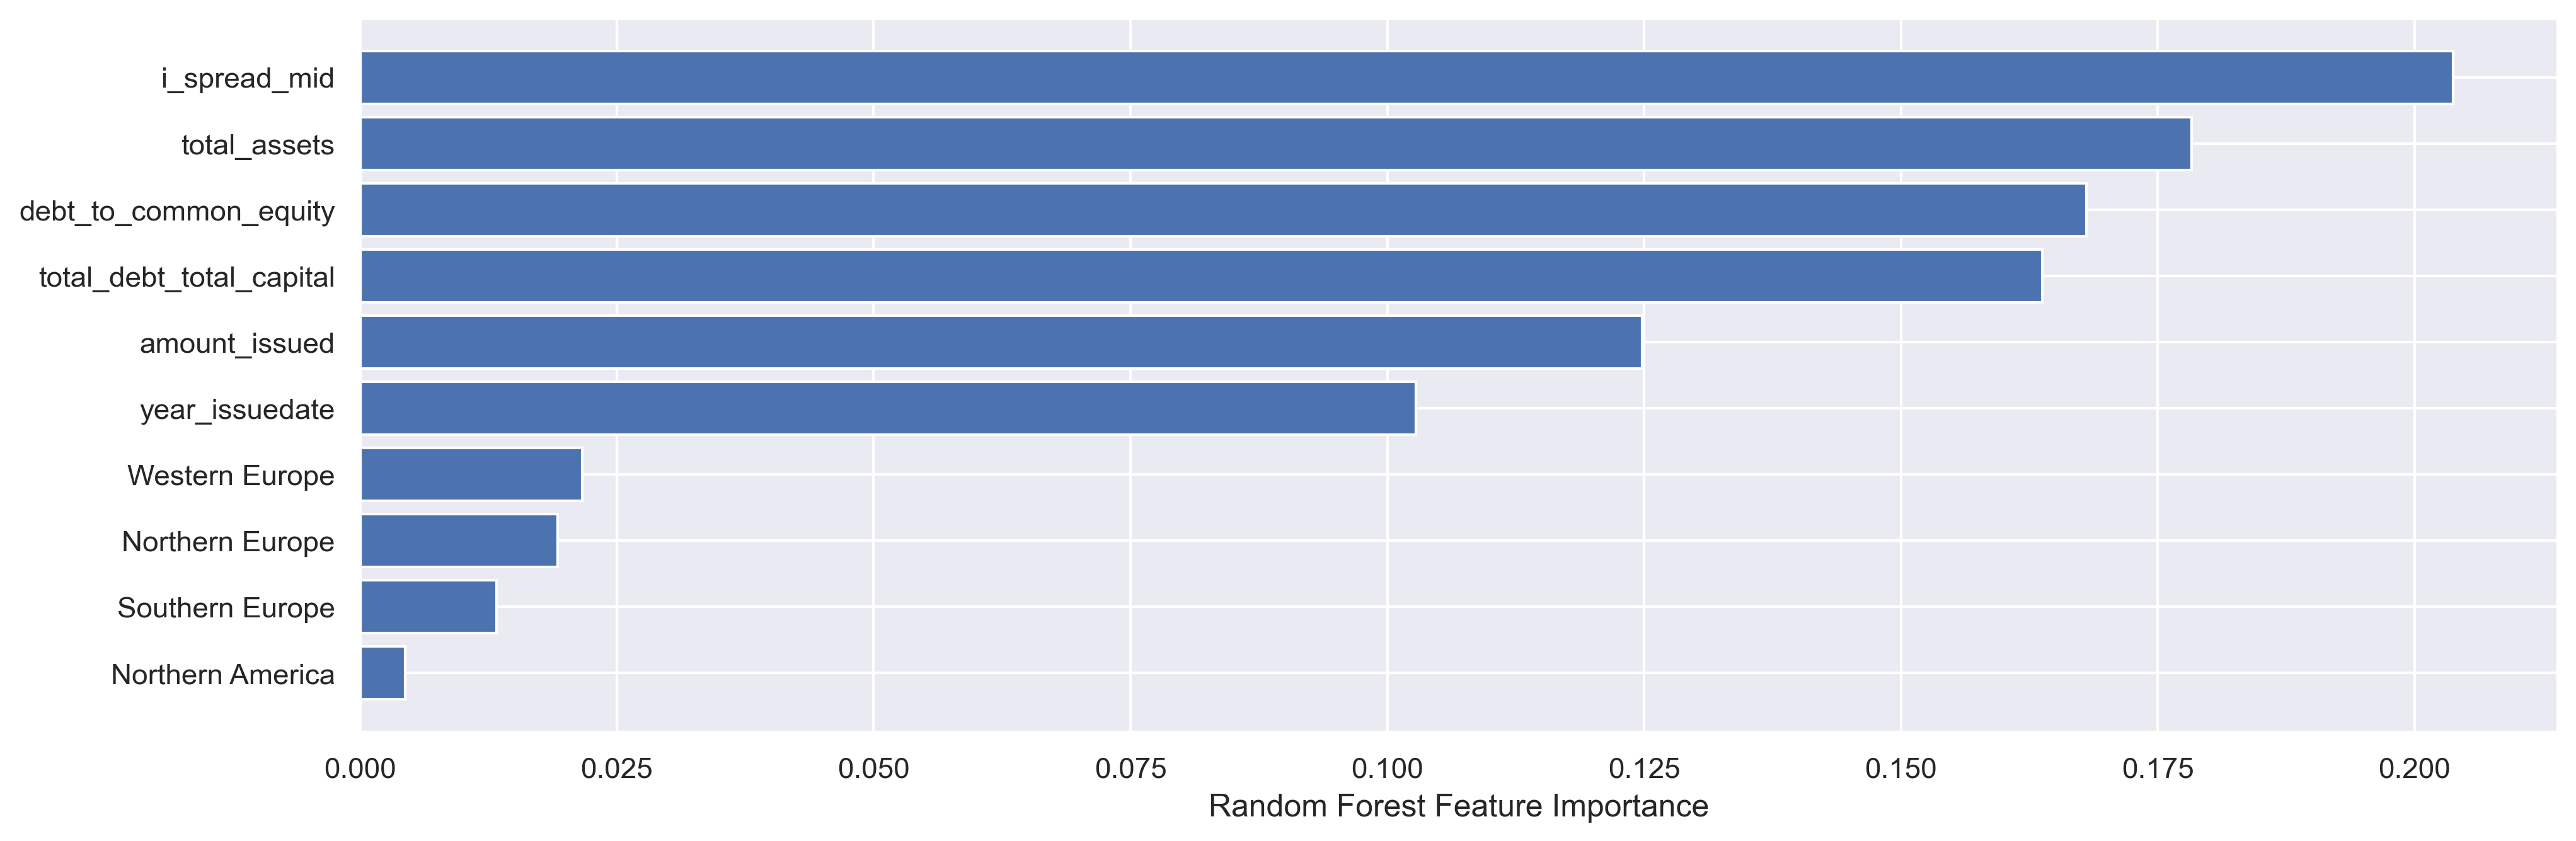

In [288]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

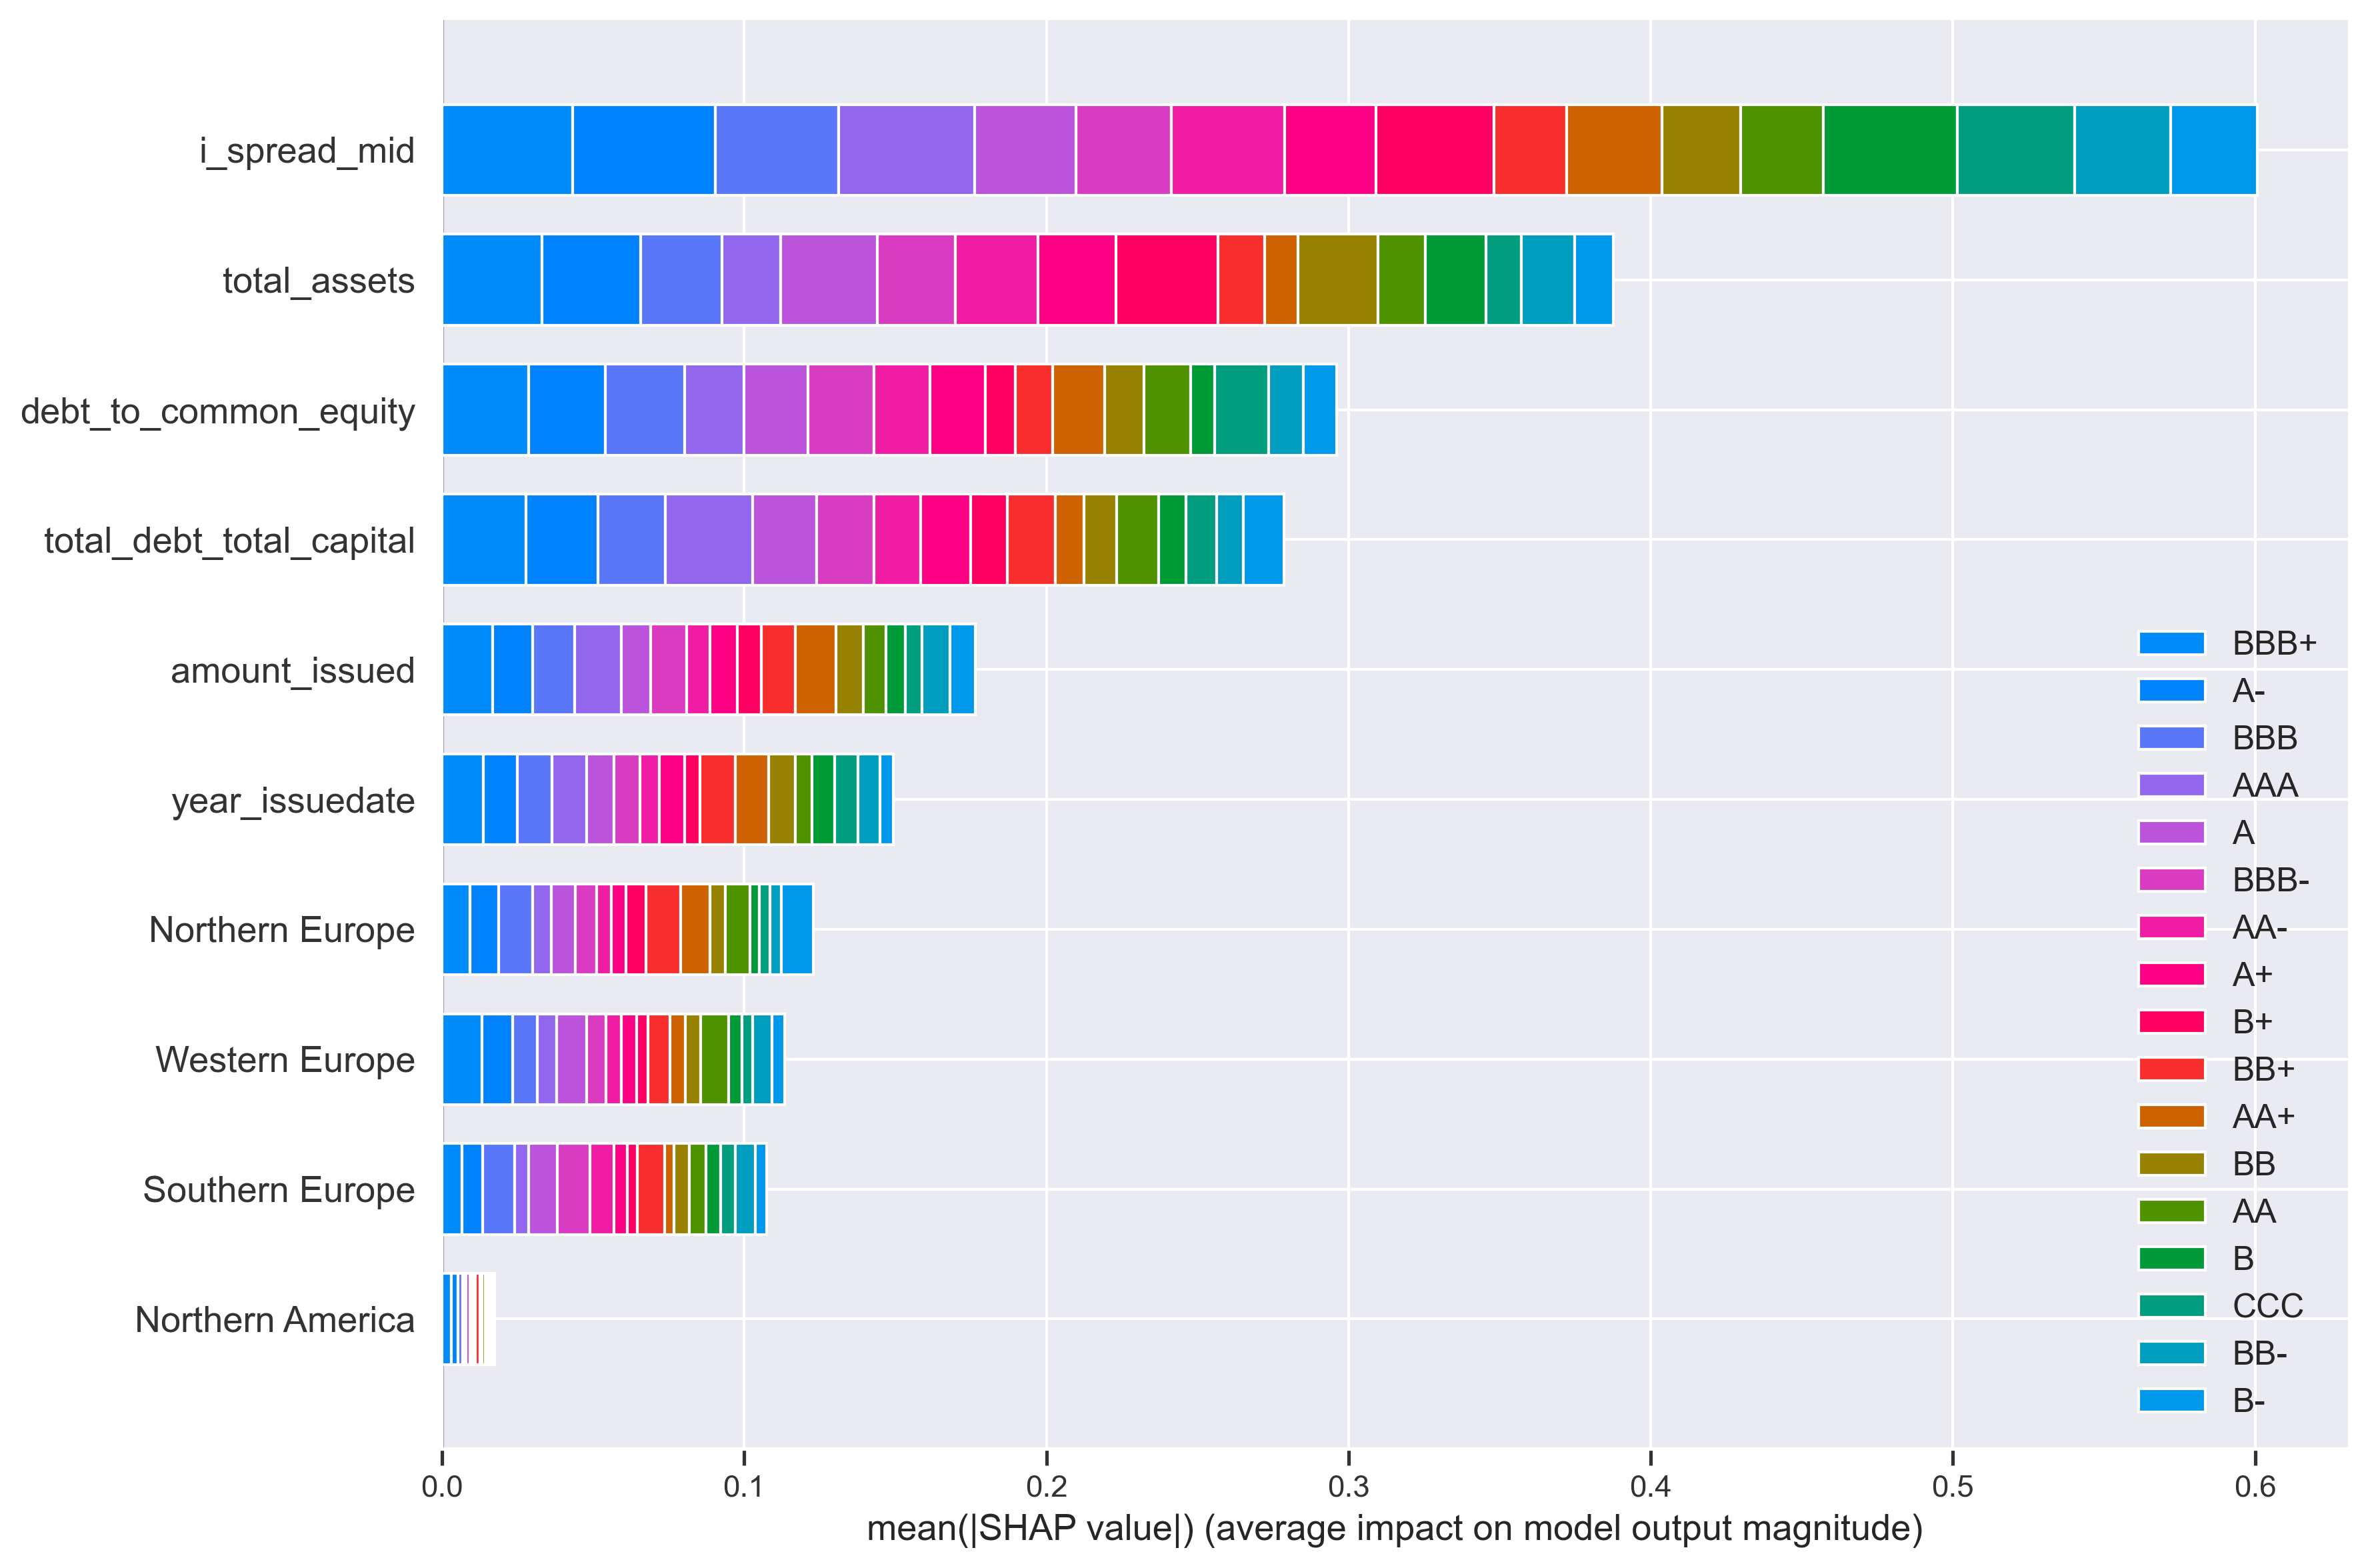

In [291]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names =list(rating_names_numbers_mapping["custom_rating_names"]), plot_size=[12,8])

### Local explainability

In [313]:
shap_values_AAA = pd.DataFrame(shap_values[0], columns = [X_test.columns])
shap_x_test = pd.concat([shap_values_AAA.reset_index(),X_test.reset_index()], axis=1)
shap_x_test.columns = ['index_1','Northern America_shap','Northern Europe_shap','Southern Europe_shap',
 'Western Europe_shap','amount_issued_shap','total_assets_shap','debt_to_common_equity_shap',
 'i_spread_mid_shap','total_debt_total_capital_shap','year_issuedate_shap', 'index_2',
 'Northern America_test','Northern Europe_test','Southern Europe_test', 'Western Europe_test',
 'amount_issued_test','total_assets_test','debt_to_common_equity_test','i_spread_mid_test',
 'total_debt_total_capital_test', 'year_issuedate_test']
shap_x_test = shap_x_test.drop(['index_1', 'index_2'], axis = 1)

print("Correlation between shap value and feature value")
print(pearsonr(np.squeeze(np.asarray(shap_x_test["Northern America_shap"])),shap_x_test["Northern America_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["Northern Europe_shap"])),shap_x_test["Northern Europe_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["Southern Europe_shap"])),shap_x_test["Southern Europe_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["Western Europe_shap"])),shap_x_test["Western Europe_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["amount_issued_shap"])),shap_x_test["amount_issued_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["total_assets_shap"])),shap_x_test["total_assets_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["debt_to_common_equity_shap"])),shap_x_test["debt_to_common_equity_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["i_spread_mid_shap"])),shap_x_test["i_spread_mid_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["total_debt_total_capital_shap"])),shap_x_test["total_debt_total_capital_test"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_x_test["year_issuedate_shap"])),shap_x_test["year_issuedate_test"])[0])

Correlation between shap value and feature value
-0.882141953376787
0.525629279211581
-0.8306829681401481
0.4827554727529998
0.540064918422574
0.13761062460514065
-0.06203634510032462
-0.4563208771621712
0.48173948237103603
0.35377883107862124


The correlations answer how important they are to one individual prediction. Next we will look how one feature value can change on prediction.

#### Southern America

Text(0.5, 1.0, 'AAA rating')

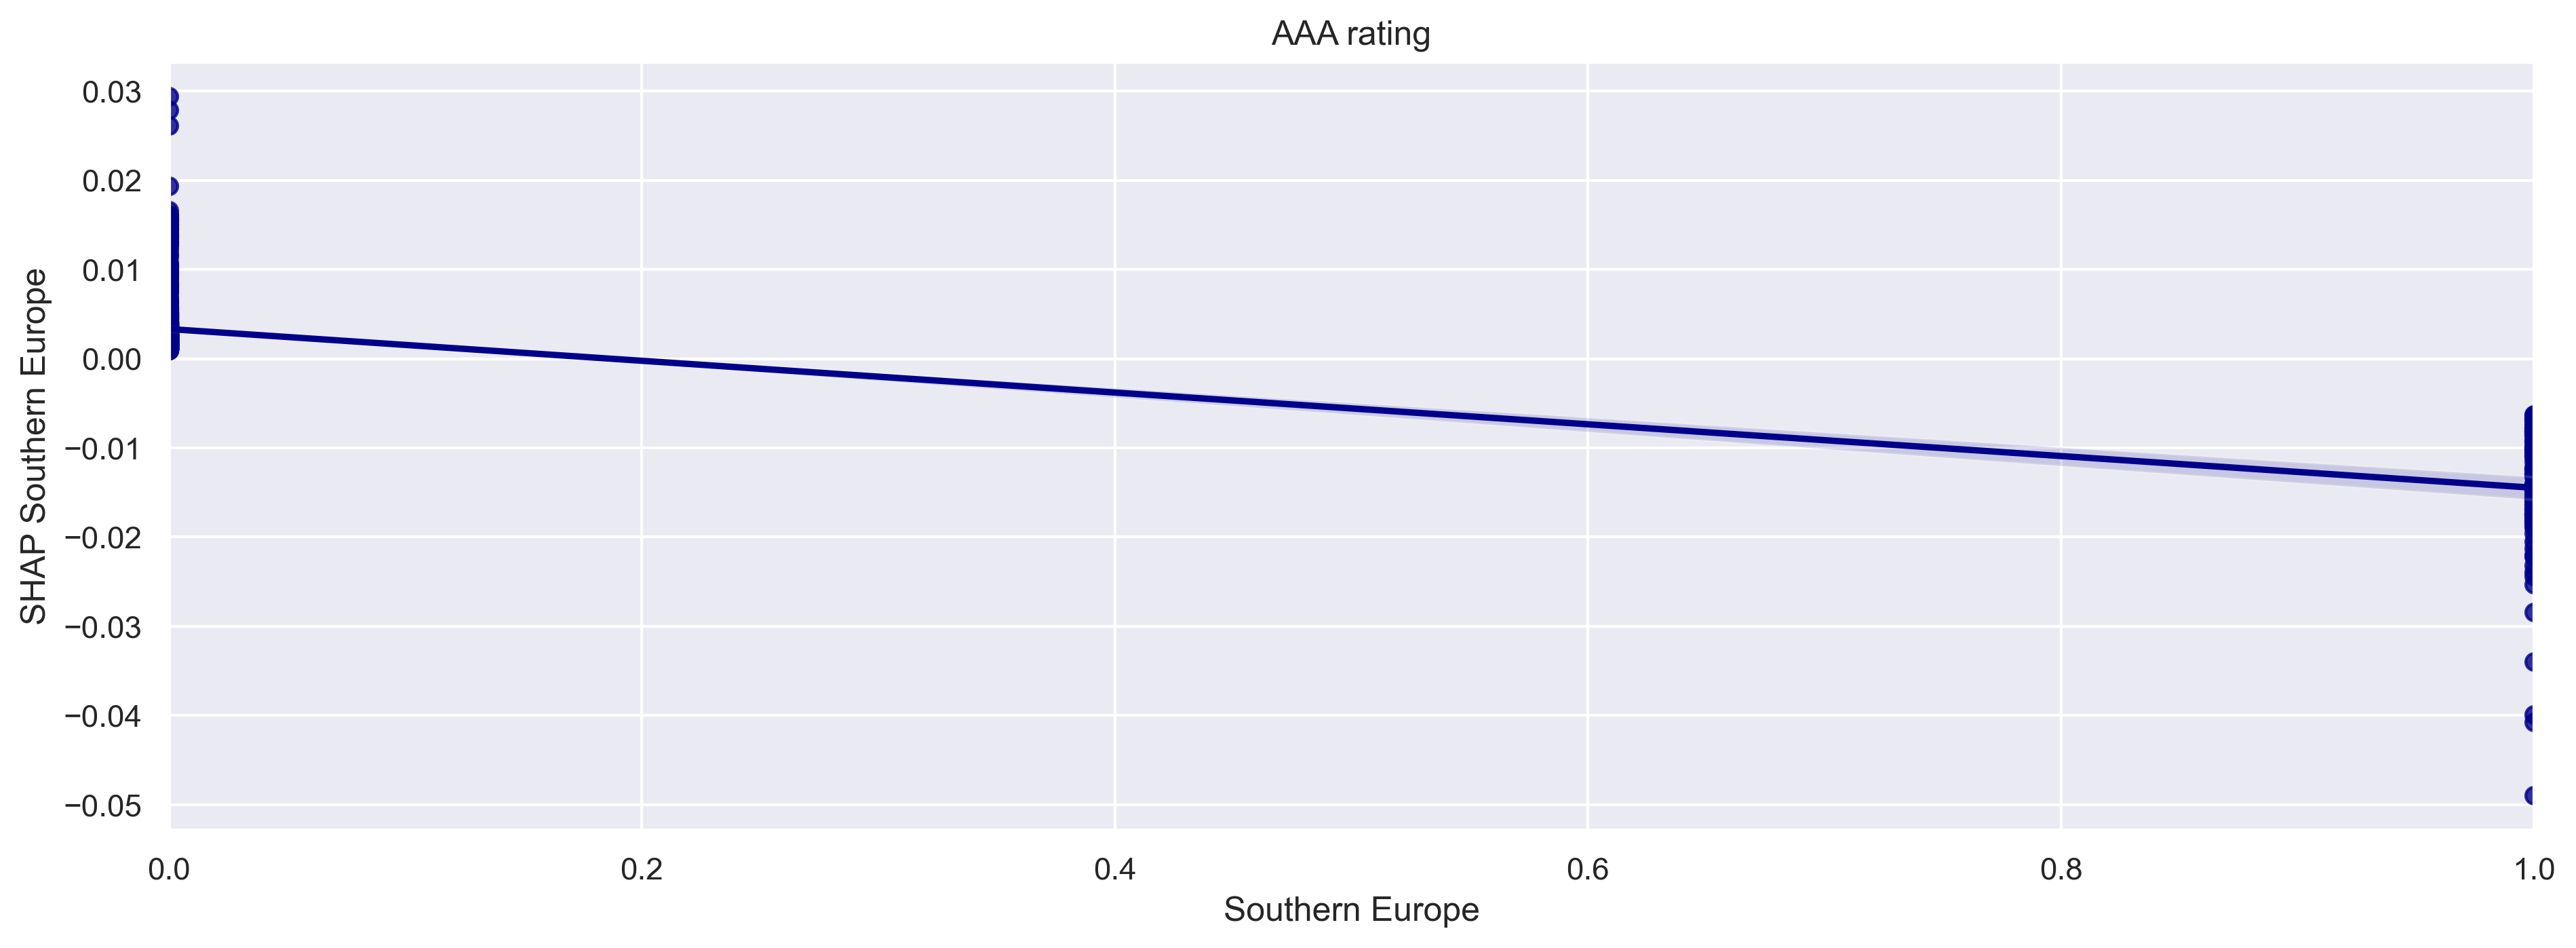

In [327]:
ax = sns.regplot(x=shap_x_test['Southern Europe_test'],
            y=shap_x_test['Southern Europe_shap'], 
            data=shap_x_test,color = 'darkblue')
ax.set(xlabel='Southern Europe', ylabel='SHAP Southern Europe')
plt.title("AAA rating")

If Southern American then less probable "AAA"

#### Amount Issued

Text(0.5, 1.0, 'AAA rating')

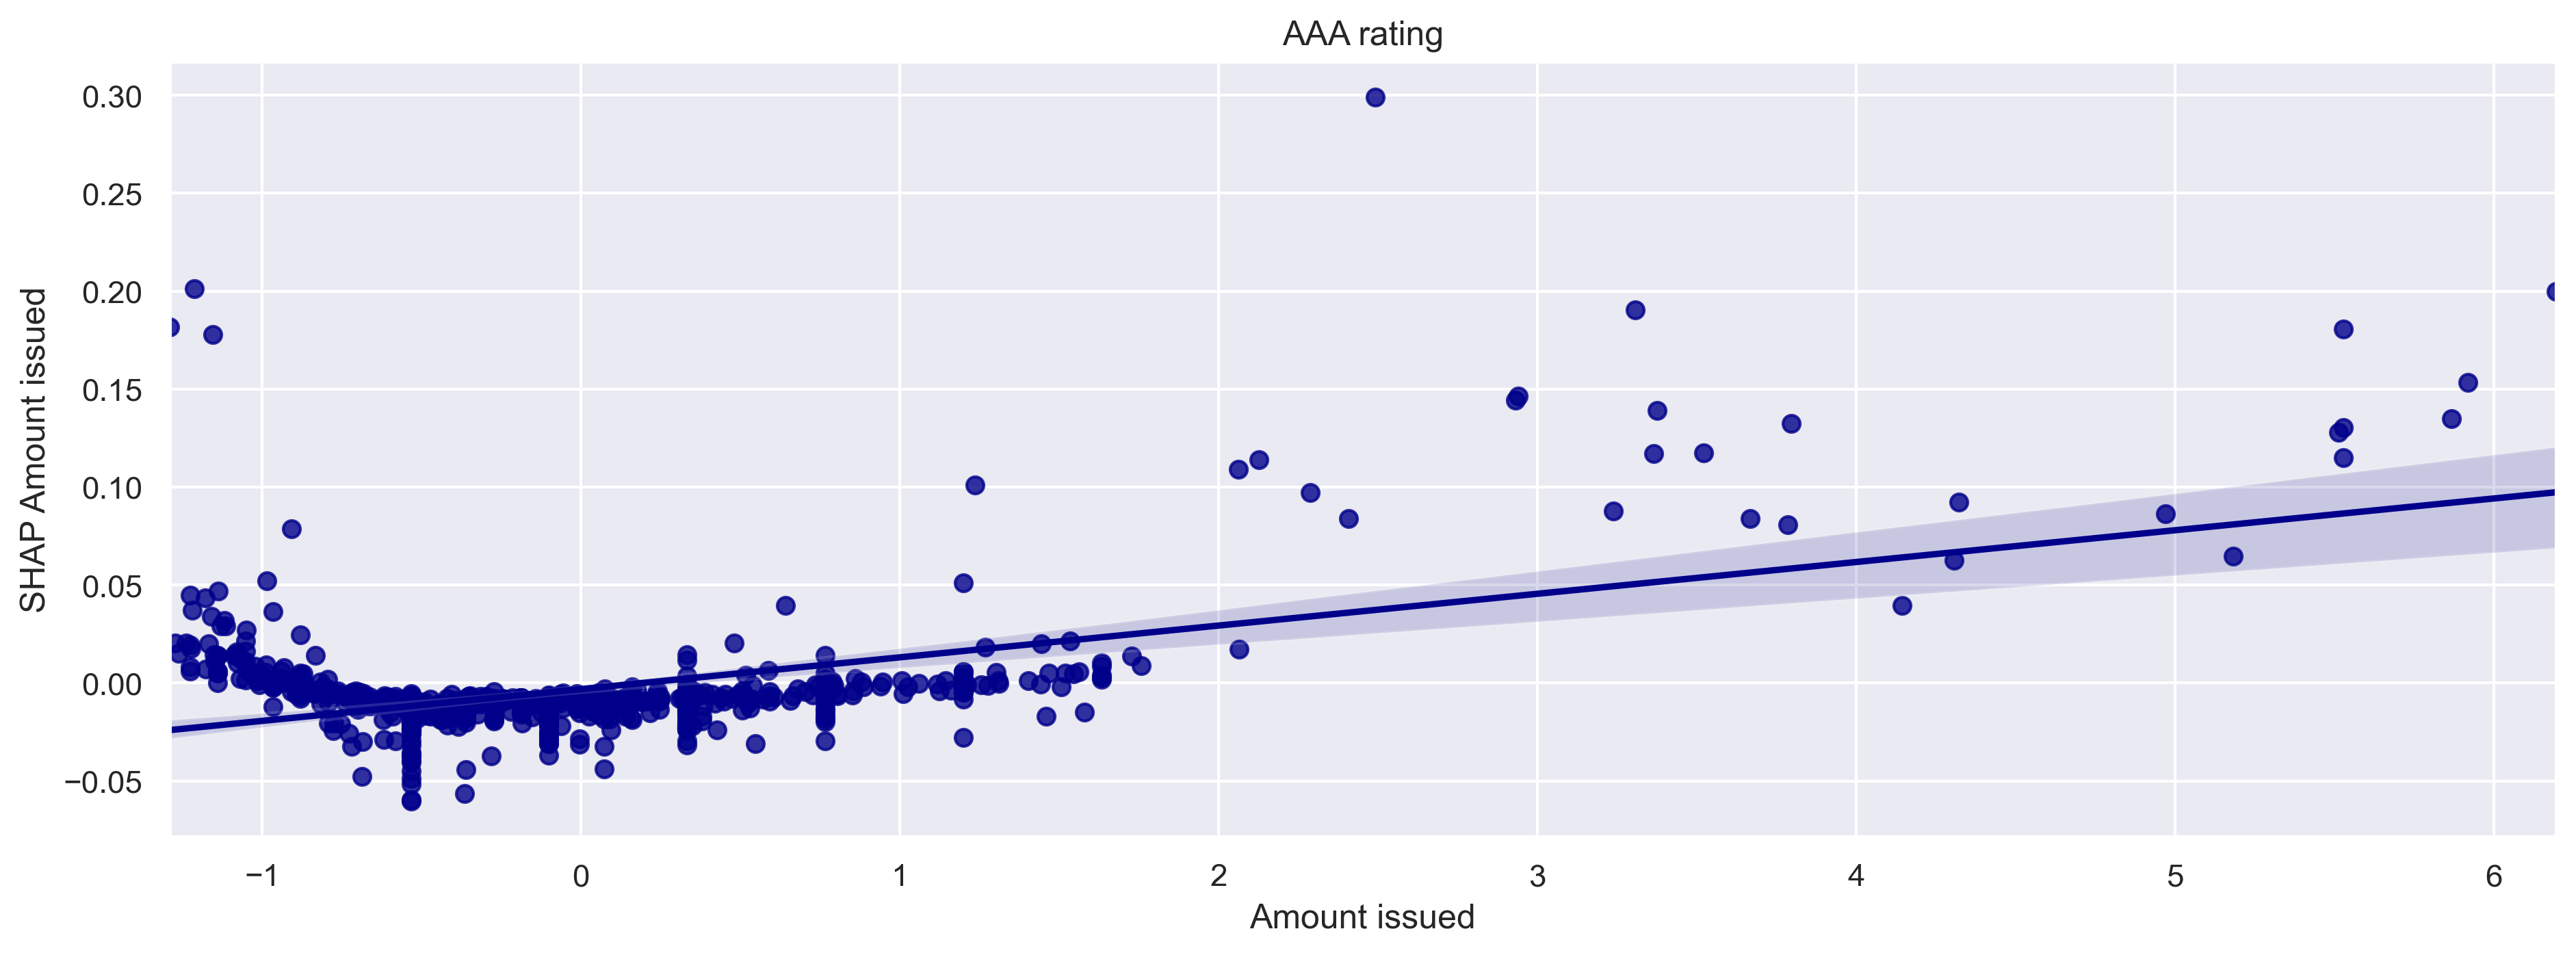

In [329]:
ax = sns.regplot(x=shap_x_test['amount_issued_test'],
            y=shap_x_test['amount_issued_shap'], 
            data=shap_x_test,color = 'darkblue')
ax.set(xlabel='Amount issued', ylabel='SHAP Amount issued')
plt.title("AAA rating")

If amount issued large then probability of "AAA" higher